## Model validation code for CF-DRR Scorecard 

### Version history : 
- Version v1
- Dated : 25th July 2023
- Last edited by : Kinsuk Ghatak (kinsuk.ghatak@pwc.com)

In [1]:
#importing python libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import r2_score
from scipy import stats
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings('ignore')#ignores all generated warnings
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import shap
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std
from sklearn.model_selection import LeaveOneOut

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score ,recall_score
from sklearn.metrics import roc_auc_score ,roc_curve, auc
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from ipysankeywidget import SankeyWidget

In [2]:
# Change the current working directory
# Import the os module
import os
os.chdir(r'C:\Users\kghatak003\OneDrive - pwc\Dual Score Card - Validation\Python_Testing_working_Lib')

### Importing Data

In [3]:
final_mdlg_data = pd.read_csv(r'C:\Users\kghatak003\OneDrive - pwc\Dual Score Card - Validation\Python_Testing_working_Lib\Data_sets_CSV\CF12b_df1v9_0120.csv')

print("Dimension of the data: ", final_mdlg_data.shape)

final_mdlg_data.head()

Dimension of the data:  (3638, 79)


,Unnamed: 0,CIF_CRM,CUSTOMERNAME,STATEMENTYEAR,STATEMENTDATE,AUDITMETHOD,STATEMENTTYPE,rbs_stmtdate,rbs_group,Sector,...,SALESTOWRKINGCAP_mod_ldr,CURRENTRATIO_ldr,QUICKRATIO_ldr,ADJQUICK_ldr,NETSALES_ldr,TOTALASSETS_ldr,EBITDA_ldr,TOTALNETWORTH_ldr,NETSALESGROWTH_ldr,OPPROFITGROWTH_ldr
0,6,100047246,"NETPROTECT, INC.",2010.0,2010-12-31,unqualif'd,annual,Balance Sheet Dependent,BS/ID,Tech,...,0.043956,0.027999,0.014679,0.012844,0.038488,0.035052,0.006593,0.021082,0.008909,0.002933
1,23,100036151,OVERSEE NET,2012.0,2012-12-31,unqualif'd,annual,CF - Other,CF,Tech,...,0.003663,0.001921,0.001099,0.002198,0.038488,0.035052,0.006593,0.009346,0.046771,0.020468
2,25,100029737,ICROSSING INC,2008.0,2008-12-31,unqualif'd,annual,Balance Sheet Dependent,BS/ID,Tech,...,0.043956,0.059627,0.036630,0.032967,0.013749,0.020604,0.022915,0.009346,0.013363,NaN
3,52,100042319,RADISYS CORPORATION,2008.0,2008-12-31,unqualif'd,annual,CF - Other,CF,Tech,...,0.005502,0.016076,0.008249,0.012844,0.009158,0.010309,0.006593,0.009346,0.008909,NaN
4,57,100027854,AUTHENTIX INC,2008.0,2008-12-31,unqualif'd,annual,CF - SLBO,CF,Tech,...,0.005502,0.016076,0.008249,0.012844,0.038488,0.020604,0.022915,0.009346,0.046771,NaN


# Section 1:  Exploratory Data Analysis and Data Quality assesment:

In [4]:

# Select the final variables for which you wnt to do the data QC analysis 


# final_selected_features=['NETSALES_ldr','GROSSMARGIN_ldr','TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']

def data_qc_analysis (variables,dataframe) :
    df_outlier_count=pd.DataFrame()
    df_summary_outlier_count=pd.DataFrame()


    
    ## Drop the customer id and dependent variable for the data QC analysis : 
#     df_copy=df_copy.drop (['customer_id','default_flag'],inplace=True,axis=1,errors='ignore')

#     df_copy=dataframe.drop(['Creditability'],axis=1,errors='ignore')
    df_copy= dataframe[variables].copy()
    
    print("Data QC Analysis report : ")
    print("\n")
    
    ##*******************Data Dimensions summary*****************************************************##
    print("Data Dimension summary:")
    
    n_rows=df_copy.shape[0]
    n_cols=df_copy.shape[1]
    numeric_cols=df_copy.select_dtypes(exclude=['object']).shape[1]
    cols=df_copy.columns
    df_data_dim_Summary=pd.DataFrame([[n_rows,n_cols,numeric_cols]],columns=['# rows','# Columns','# numeric cols'])
    display(df_data_dim_Summary)
    print("\n")
    
    
    ##*************Missing value analysis *********************************************************##
    
    print("Missing value summary:")
    percent_missing=df_copy.isnull().sum()*100/len(df_copy)
    missing_value_df=pd.DataFrame({'Column_Name':df_copy.columns,
                                  'Percent_Missing':percent_missing})
    missing_value_df.sort_values('Percent_Missing',inplace=True,ascending=False)
    print("\n")
    print("Top Missing Values:")
    
    display(missing_value_df.head(10))
    
    
    ###**Convert variables to numeric formats ***##
    df_copy.iloc[:,:]=df_copy.iloc[:,:].apply(pd.to_numeric)
    
    
    ##******************Summary Statistics analysis **********************************************##
    df_copy_descrb=df_copy[variables].describe([.05,.25,.5,.75,.9,.95,.99])
    print("\n")
    print("Summary statistics:")
    
    display(df_copy_descrb.T)
    
    ##***************************Outlier Analysis ***************************##
    df1=df_copy_descrb[variables].copy()
    
    for column in df1:
        Q1=np.percentile(df1[column],25,interpolation='midpoint')
        Q3=np.percentile(df1[column],75,interpolation='midpoint')
        IQR=Q3-Q1
        upper=Q3+1.5*IQR
        lower=Q1-1.5*IQR
        max_val=max(df1[column])
        min_val=min(df1[column])
        
        
        #Count of obs above upper bound and below lower bound:
        upper_obs=df1[column]>=(Q3+1.5*IQR)
        upper_count=upper_obs.sum()
        
        lower_obs=df1[column]<=(Q1-1.5*IQR)
        lower_count=lower_obs.sum()
        
        total_outlier_count=upper_count+lower_count
        
        df_outlier_count=pd.DataFrame([[column,total_outlier_count,upper_count,lower_count,max_val,min_val]],
                                      columns=['column_name','total_outlier_count','upper_outlier_count',
                                               'lower_outlier_count','max_value','min_value'])
        
        df_summary_outlier_count=df_summary_outlier_count.append(df_outlier_count)
    print("\n")
    print("Outlier analysis summary for the chosen variaables :")
    display(df_summary_outlier_count)

          
    ##***************************Box plots for all the chosen variables for outlier Analysis ***************************##
    
    print("Box plot for the chosen variables:")
    print("\n")
    
    df2=df_copy[variables].select_dtypes(exclude=['object'])
        
    for column in df2:
        plt.figure(figsize=(10,1))
        sns.boxplot(data=df2,x=column)
        
    
    
    
    

Data QC Analysis report : 


Data Dimension summary:


,# rows,# Columns,# numeric cols
0,3638,10,10




Missing value summary:


Top Missing Values:


,Column_Name,Percent_Missing
NETSALES_ldr,NETSALES_ldr,0.0
GROSSMARGIN_ldr,GROSSMARGIN_ldr,0.0
TDEBITDA_mod_ldr,TDEBITDA_mod_ldr,0.0
CURRENTRATIO_ldr,CURRENTRATIO_ldr,0.0
FIXEDCHARGECOVER_ldr,FIXEDCHARGECOVER_ldr,0.0
NETSALES,NETSALES,0.0
GROSSMARGIN,GROSSMARGIN,0.0
TDEBITDA_mod,TDEBITDA_mod,0.0
CURRENTRATIO,CURRENTRATIO,0.0
FIXEDCHARGECOVER,FIXEDCHARGECOVER,0.0




Summary statistics:


,count,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
NETSALES_ldr,3638.0,2.226498e-02,1.336519e-02,9.157509e-03,9.157509e-03,9.157509e-03,1.374885e-02,3.848797e-02,3.848797e-02,3.848797e-02,3.848797e-02,3.848797e-02
GROSSMARGIN_ldr,3638.0,2.250331e-02,1.302444e-02,2.706638e-03,2.706638e-03,1.061063e-02,2.171344e-02,3.540813e-02,4.296529e-02,4.296529e-02,4.296529e-02,4.296529e-02
TDEBITDA_mod_ldr,3638.0,2.246891e-02,1.235292e-02,4.954809e-03,4.954809e-03,9.778277e-03,2.763574e-02,2.763574e-02,2.763574e-02,6.010929e-02,6.010929e-02,6.010929e-02
CURRENTRATIO_ldr,3638.0,1.984259e-02,1.867764e-02,1.515736e-03,1.515736e-03,1.921207e-03,1.607601e-02,2.799916e-02,5.962743e-02,5.962743e-02,5.962743e-02,5.962743e-02
FIXEDCHARGECOVER_ldr,3638.0,2.226498e-02,1.455726e-02,2.747253e-03,2.747253e-03,7.590133e-03,2.612056e-02,3.628367e-02,3.628367e-02,3.628367e-02,3.628367e-02,3.628367e-02
NETSALES,3638.0,3.082442e+08,1.913391e+09,1.711000e+06,2.559675e+07,8.758625e+07,1.368020e+08,2.540275e+08,5.486297e+08,8.703474e+08,2.211344e+09,1.038830e+11
GROSSMARGIN,3638.0,5.804450e+01,2.418921e+01,-1.205311e+02,1.729253e+01,4.081361e+01,6.017864e+01,7.550598e+01,8.910114e+01,1.000000e+02,1.000000e+02,1.000000e+02
TDEBITDA_mod,3638.0,1.241804e+01,6.733934e+01,1.750000e-04,2.809331e-01,2.659472e+00,1.260469e+01,1.260469e+01,1.260469e+01,1.264389e+01,7.478780e+01,2.504000e+03
CURRENTRATIO,3638.0,2.097430e+00,1.975270e+00,-2.994902e+00,5.361452e-01,9.862795e-01,1.506406e+00,2.510616e+00,4.049150e+00,5.550763e+00,9.680284e+00,2.498660e+01
FIXEDCHARGECOVER,3638.0,-2.204536e+01,1.558375e+03,-4.829300e+04,-9.990000e+02,-5.796478e+00,8.368640e-01,4.521705e+00,4.708261e+01,9.990000e+02,9.990000e+02,4.365700e+04




Outlier analysis summary for the chosen variaables :


,column_name,total_outlier_count,upper_outlier_count,lower_outlier_count,max_value,min_value
0,NETSALES_ldr,1,1,0,3.638000e+03,0.009158
0,GROSSMARGIN_ldr,1,1,0,3.638000e+03,0.002707
0,TDEBITDA_mod_ldr,1,1,0,3.638000e+03,0.004955
0,CURRENTRATIO_ldr,1,1,0,3.638000e+03,0.001516
0,FIXEDCHARGECOVER_ldr,1,1,0,3.638000e+03,0.002747
0,NETSALES,1,1,0,1.038830e+11,3638.000000
0,GROSSMARGIN,2,1,1,3.638000e+03,-120.531128
0,TDEBITDA_mod,2,2,0,3.638000e+03,0.000175
0,CURRENTRATIO,2,2,0,3.638000e+03,-2.994902
0,FIXEDCHARGECOVER,3,2,1,4.365700e+04,-48293.000000


Box plot for the chosen variables:




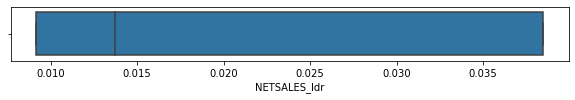

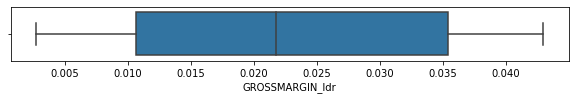

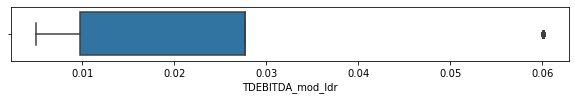

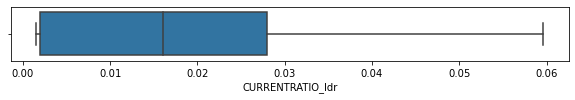

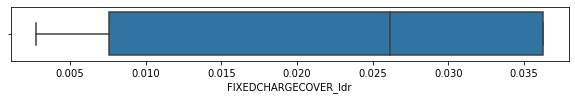

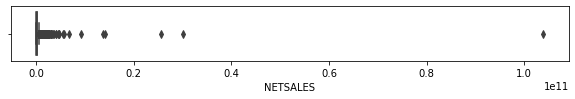

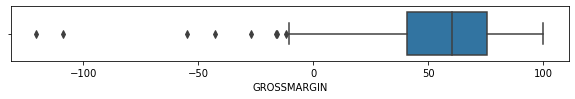

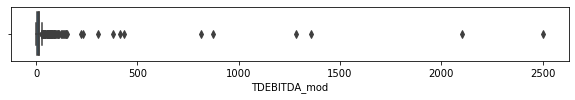

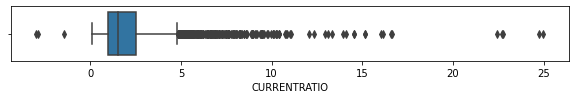

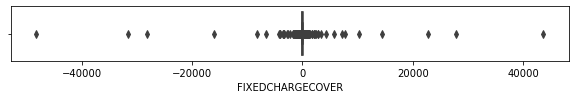

In [5]:

final_selected_features_transformed=['NETSALES_ldr','GROSSMARGIN_ldr','TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']
final_selected_features_raw=['NETSALES','GROSSMARGIN','TDEBITDA_mod','CURRENTRATIO','FIXEDCHARGECOVER']

final_mdlg_data['NETSALES']=final_mdlg_data['NETSALES']*1000   ## assuming  NETSALES is in '000

total_feature_list=final_selected_features_transformed+final_selected_features_raw

# final_mdlg_data[final_selected_features]
data_qc_analysis(total_feature_list,final_mdlg_data)

## Sec 1.2 Report generation using Sweetviz: 

In [7]:
#creating a EDA report using sweetviz
import sweetviz as sv
analyze_report = sv.analyze(final_mdlg_data[total_feature_list])
analyze_report.show_html('sweetviz_EDA.html', open_browser= True) #Change open_browser to TRUE if you intend to display the report in browser 

                                             |                                             | [  0%]   00:00 ->…

Report sweetviz_EDA.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Sec 1.3 Default rate analysis : 

In [4]:
final_mdlg_data.columns

Index(['Unnamed: 0', 'CIF_CRM', 'CUSTOMERNAME', 'STATEMENTYEAR',
       'STATEMENTDATE', 'AUDITMETHOD', 'STATEMENTTYPE', 'rbs_stmtdate',
       'rbs_group', 'Sector', 'Sector2', 'mcrr', 'mcrr3', 'default_flag',
       'default_flag2', 'default_flag3', 'default_flag4', 'NETSALES',
       'TOTALASSETS', 'TOTALNETWORTH', 'EBITDA', 'FUNDEDDEBT', 'FUNDEDSRDEBT',
       'LONGTERMDEBT', 'WORKINGCAPITAL', 'GROSSMARGIN', 'NETMARGIN',
       'OPPROFITMARGIN', 'RETURNONASSETS', 'RETURNONEQUITY', 'DEBTTOTNW',
       'DEBTTOWORTH', 'LIABSTOASSETS', 'SRDEBITDA', 'TDEBITDA',
       'TOTLIABSNETWORTH', 'ADJQUICK', 'CURRENTRATIO', 'QUICKRATIO',
       'SALESTOWRKINGCAP', 'CASHFLWTOPPCPLTD', 'EBITDATOINTCPLTD',
       'FIXEDCHARGECOVER', 'FNDSFLWTOPPCPLTD', 'INTERESTCOVERAGE',
       'UCACASHFLOWCOVER', 'NETSALESGROWTH', 'OPPROFITGROWTH',
       'TOTALASSETSGROWTH', 'FDEBITDA', 'LTDEBITDA', 'LIABSTOASSETS_ldr',
       'DEBTTOWORTH_ldr', 'TDEBITDA_ldr', 'TDEBITDA_mod', 'TDEBITDA_mod_ldr',
       'LTDEBIT

In [5]:
dr_data=final_mdlg_data[['STATEMENTYEAR','STATEMENTDATE','rbs_group','rbs_stmtdate','default_flag','default_flag2','default_flag3','Sector','Sector2']]
dr_data.head()

,STATEMENTYEAR,STATEMENTDATE,rbs_group,rbs_stmtdate,default_flag,default_flag2,default_flag3,Sector,Sector2
0,2010.0,2010-12-31,BS/ID,Balance Sheet Dependent,0,0,0,Tech,Tech
1,2012.0,2012-12-31,CF,CF - Other,0,0,0,Tech,Tech
2,2008.0,2008-12-31,BS/ID,Balance Sheet Dependent,0,0,0,Tech,Tech
3,2008.0,2008-12-31,CF,CF - Other,0,0,0,Tech,Tech
4,2008.0,2008-12-31,CF,CF - SLBO,0,0,0,Tech,Tech


,STATEMENTYEAR,Count,total_defaults,DR_DF_3_pctg
0,2007.0,81,0,0.000000
1,2008.0,120,3,2.500000
2,2009.0,116,0,0.000000
3,2010.0,145,0,0.000000
4,2011.0,162,4,2.469136
5,2012.0,193,1,0.518135
6,2013.0,221,5,2.262443
7,2014.0,264,7,2.651515
8,2015.0,294,12,4.081633
9,2016.0,294,6,2.040816


count    16.000000
mean      1.938360
std       1.218163
min       0.000000
25%       1.397139
50%       2.242333
75%       2.537879
max       4.081633
Name: DR_DF_3_pctg, dtype: float64

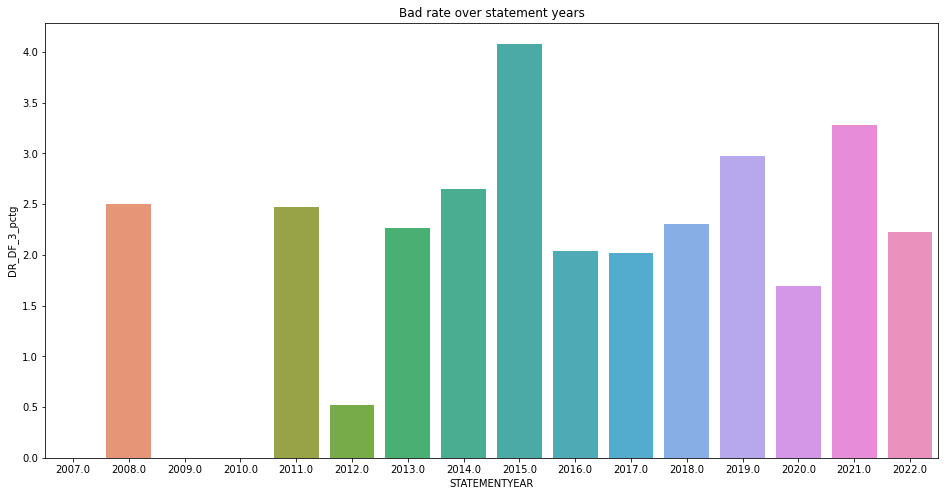

In [6]:
## Year wise DR analysis :
import seaborn as sns
import matplotlib.pyplot as plt



dr_df_year=dr_data.groupby('STATEMENTYEAR').agg({'rbs_group':'count','default_flag3':'sum'}).\
rename(columns={'default_flag3':'total_defaults','rbs_group':'Count'}).reset_index()

dr_df_year['DR_DF_3_pctg']=dr_df_year['total_defaults']*100/dr_df_year['Count']



display(dr_df_year)

display((dr_df_year['DR_DF_3_pctg'].describe()))

# # draw lineplot

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(16, 8))
 

sns.barplot(x="STATEMENTYEAR", y="DR_DF_3_pctg", data=dr_df_year,  ax=ax).set(title='Bad rate over statement years')
plt.show()

,rbs_group,Count,total_defaults,DR_DF_3_pctg
0,BS/ID,1189,39,3.28
1,CF,2449,42,1.71


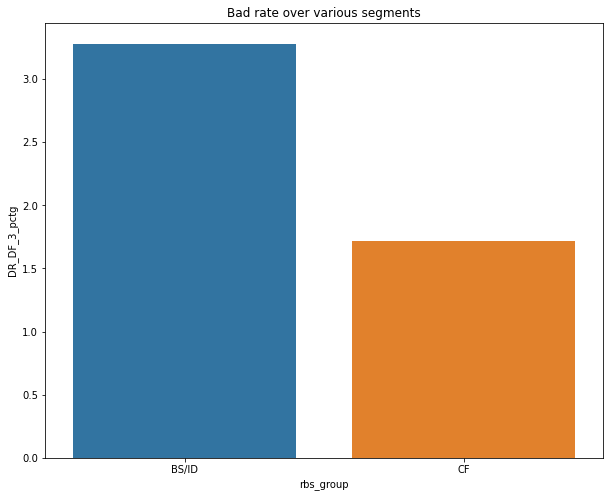

In [59]:
## rbs_group wise DR analysis :
import seaborn as sns
import matplotlib.pyplot as plt



dr_df_rbs=dr_data.groupby('rbs_group').agg({'STATEMENTYEAR':'count','default_flag3':'sum'}).\
rename(columns={'default_flag3':'total_defaults','STATEMENTYEAR':'Count'}).reset_index()

dr_df_rbs['DR_DF_3_pctg']=dr_df_rbs['total_defaults']*100/dr_df_rbs['Count']



display(dr_df_rbs)

# # draw lineplot

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(10, 8))
 

sns.barplot(x="rbs_group", y="DR_DF_3_pctg", data=dr_df_rbs,  ax=ax).set(title='Bad rate over various segments')
plt.show()

,rbs_stmtdate,Count,total_defaults,DR_DF_3_pctg
0,Balance Sheet Dependent,911,27,2.963776
1,CF - Other,1679,14,0.833830
2,CF - SLBO,770,28,3.636364
3,ID - Later Stage,278,12,4.316547


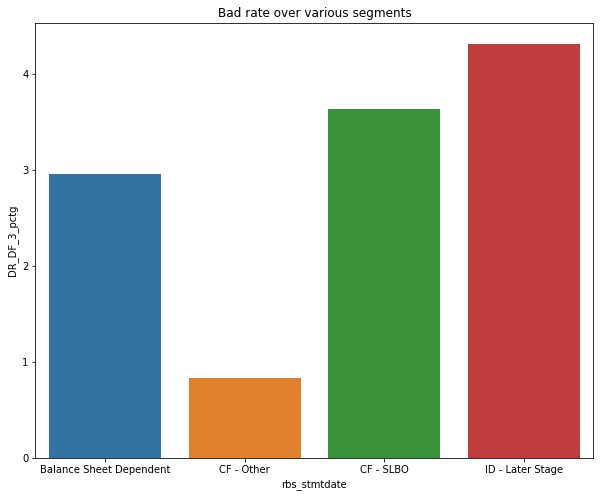

In [5]:
## rbs_stmtdate wise DR analysis :
import seaborn as sns
import matplotlib.pyplot as plt



dr_df_rbs=dr_data.groupby('rbs_stmtdate').agg({'STATEMENTYEAR':'count','default_flag3':'sum'}).\
rename(columns={'default_flag3':'total_defaults','STATEMENTYEAR':'Count'}).reset_index()

dr_df_rbs['DR_DF_3_pctg']=dr_df_rbs['total_defaults']*100/dr_df_rbs['Count']



display(dr_df_rbs)

# # draw lineplot

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(10, 8))
 

sns.barplot(x="rbs_stmtdate", y="DR_DF_3_pctg", data=dr_df_rbs,  ax=ax).set(title='Bad rate over various segments')
plt.show()

,rbs_stmtdate,Count,total_defaults,Default_Rate
0,Balance Sheet Dependent,806,20,2.481390
1,CF - Other,1449,12,0.828157
2,CF - SLBO,708,26,3.672316
3,ID - Later Stage,219,9,4.109589


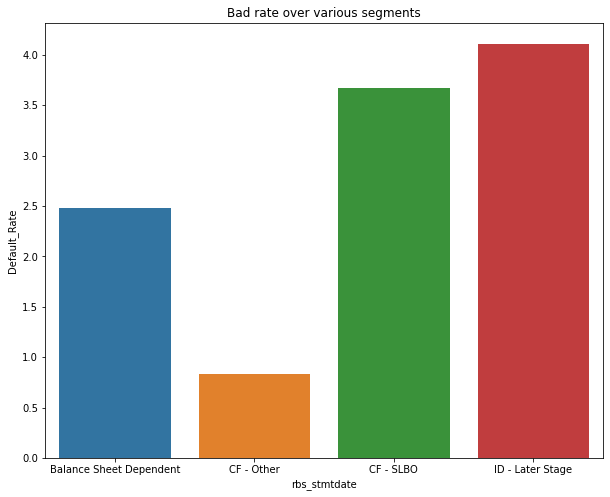

In [9]:
## rbs_stmtdate wise DR analysis only on development data :
import seaborn as sns
import matplotlib.pyplot as plt


dr_data_dev=dr_data[dr_data['STATEMENTYEAR']<2021]

dr_df_rbs=dr_data_dev.groupby('rbs_stmtdate').agg({'STATEMENTYEAR':'count','default_flag3':'sum'}).\
rename(columns={'default_flag3':'total_defaults','STATEMENTYEAR':'Count'}).reset_index()

dr_df_rbs['Default_Rate']=dr_df_rbs['total_defaults']*100/dr_df_rbs['Count']



display(dr_df_rbs)

# # draw lineplot

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(10, 8))
 

sns.barplot(x="rbs_stmtdate", y="Default_Rate", data=dr_df_rbs,  ax=ax).set(title='Bad rate over various segments')
plt.show()

In [61]:
## Cross tab between rbs_stmtdate and rbs_group

pd.crosstab(dr_data['rbs_group'],dr_data['rbs_stmtdate'])

rbs_stmtdate,Balance Sheet Dependent,CF - Other,CF - SLBO,ID - Later Stage
rbs_group,,,,
BS/ID,911,0,0,278
CF,0,1679,770,0


,Sector,DR_DF_3,DR_DF_3_pctg
0,Health,0.015674,1.567398
1,Other,0.041096,4.109589
2,Tech,0.022775,2.277505


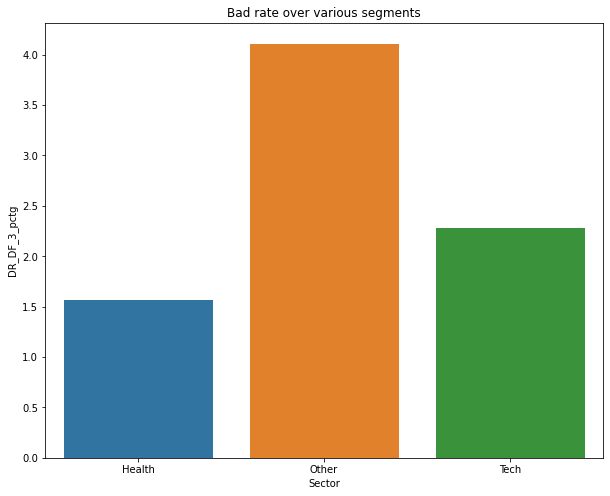

In [26]:
## Sector wise DR analysis :
import seaborn as sns
import matplotlib.pyplot as plt



dr_df_sector=dr_data.groupby('Sector').agg({'default_flag3':'mean'}).rename(columns={'default_flag3':'DR_DF_3'}).reset_index()

dr_df_sector['DR_DF_3_pctg']=dr_df_sector['DR_DF_3']*100

display(dr_df_sector)

# # draw lineplot

# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(10, 8))
 

sns.barplot(x="Sector", y="DR_DF_3_pctg", data=dr_df_sector,  ax=ax).set(title='Bad rate over various segments')
plt.show()

In [ ]:
## Chi Sq test to understand association between default flag and segments: 

In [ ]:
from fpdf import FPDF
class PDF(FPDF):
    def header(self):
        # Header settings (optional)
        pass

    def footer(self):
        # Footer settings (optional)
        pass

    def chapter_title(self, title):
        # Chapter title settings (optional)
        pass

    def chapter_body(self, text):
        # Chapter body settings (optional)
        pass

    def add_dataframe(self, dataframe):
        # Add dataframe to the PDF
        pass

    def add_boxplot(self, boxplot):
        # Add boxplot to the PDF
        pass

    def add_page_break(self):
        # Add a page break to the PDF
        pass


In [ ]:



variables=final_selected_features_transformed+final_selected_features_raw

df_copy= final_mdlg_data[variables].copy()

df_outlier_count=pd.DataFrame()
df_summary_outlier_count=pd.DataFrame()

##*********************************** Missing value analysis *********************************************************##



print("Missing value summary:")
percent_missing=df_copy.isnull().sum()*100/len(df_copy)
missing_value_df=pd.DataFrame({'Column_Name':df_copy.columns,
                              'Percent_Missing':percent_missing})
missing_value_df.sort_values('Percent_Missing',inplace=True,ascending=False)


##***************************************** Summary Statistics analysis **********************************************##
df_copy_descrb=df_copy[variables].describe([.05,.25,.5,.75,.9,.95,.99])
df_copy_descrb_T=df_copy_descrb.T



##***************************************** Outlier Analysis **********************************************************##
df1=df_copy_descrb[variables].copy()

for column in df1:
    Q1=np.percentile(df1[column],25,interpolation='midpoint')
    Q3=np.percentile(df1[column],75,interpolation='midpoint')
    IQR=Q3-Q1
    upper=Q3+1.5*IQR
    lower=Q1-1.5*IQR
    max_val=max(df1[column])
    min_val=min(df1[column])


    #Count of obs above upper bound and below lower bound:
    upper_obs=df1[column]>=(Q3+1.5*IQR)
    upper_count=upper_obs.sum()

    lower_obs=df1[column]<=(Q1-1.5*IQR)
    lower_count=lower_obs.sum()

    total_outlier_count=upper_count+lower_count

    df_outlier_count=pd.DataFrame([[column,total_outlier_count,upper_count,lower_count,max_val,min_val]],
                                  columns=['column_name','total_outlier_count','upper_outlier_count',
                                           'lower_outlier_count','max_value','min_value'])

    df_summary_outlier_count=df_summary_outlier_count.append(df_outlier_count)
    


    
##***************************Box plots for all the chosen variables for outlier Analysis ***************************##



# df2=df_copy[variables].select_dtypes(exclude=['object'])

# for column in df2:
#     plt.figure(figsize=(10,1))
#     sns.boxplot(data=df2,x=column)


    


In [ ]:
df_copy_descrb_T

In [ ]:

# Instantiate the PDF class
pdf = PDF()

# Add a chapter for the dataframes
pdf.chapter_title("Missing value Dataframe")
pdf.chapter_body("Missing value summary:")
# Add your dataframes to the PDF
pdf.add_dataframe(missing_value_df)
pdf.add_page_break()


# Add a chapter for the dataframes
pdf.chapter_title("Summary Dataframes")
pdf.chapter_body("Summary Statistics:")
# Add your dataframes to the PDF
pdf.add_dataframe(df_copy_descrb_T)
pdf.add_page_break()


# Add a chapter for the dataframes
pdf.chapter_title("Outlier Dataframes")
pdf.chapter_body("Outlier Analysis ")
# Add your dataframes to the PDF
pdf.add_dataframe(df_summary_outlier_count)
# pdf.add_page_break()
# pdf.add_dataframe(dataframe2)
# pdf.add_page_break()

# Add a chapter for the boxplots
# pdf.chapter_title("Boxplots")
# pdf.chapter_body("Description of the boxplots:")

# # Add your boxplots to the PDF
# pdf.add_boxplot(boxplot1)
# pdf.add_page_break()

# pdf.add_boxplot(boxplot2)

# Save the PDF
pdf.output("DataQC_Analysis.pdf")


# Sec 2 : Independent Replication of the model: 

### Sec 2.1 : Replicate client's code on feature selection : 

In [6]:
##Set up : 

import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score, recall_score, precision_score
from sklearn.metrics import average_precision_score, f1_score, classification_report
from sklearn.metrics import accuracy_score, plot_roc_curve, plot_precision_recall_curve, plot_confusion_matrix
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator, ScalarFormatter)

import itertools

pd.options.display.float_format = '{:,.2f}'.format
# out_path = "C:\\Users\\kusingh\\OneDrive - Silicon Valley Bank\\Documents\\02 Work\\CF Scorecards\\python_out\\CF_MRM\\"
GLOBAL_SEED = 888

In [7]:
df_oot = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] >= 2021,:].copy()
df_dev = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] < 2021,:].copy()

random_seed = GLOBAL_SEED
df_train, df_test = train_test_split(df_dev, test_size=0.2, random_state=random_seed, stratify=df_dev['default_flag3'])


print('df_oot:',np.sort(df_oot.STATEMENTYEAR.unique()))
print('df_dev:',np.sort(df_dev.STATEMENTYEAR.unique()))
print('df_oot:',df_oot.shape)
print('df_dev:',df_dev.shape)


print('Defaults and Default Rates: ')
print('total count train:',df_train['default_flag3'].count())
print('total Defaults train:',df_train['default_flag3'].sum())
print(' DR train:',df_train['default_flag3'].mean())

print('total Defaults test:',df_test['default_flag3'].sum())
print(' DR train:',df_test['default_flag3'].mean())

print('total Defaults OOT:',df_oot['default_flag3'].sum())
print(' DR train:',df_oot['default_flag3'].mean())


#output:

df_oot: [2021. 2022.]
df_dev: [2007. 2008. 2009. 2010. 2011. 2012. 2013. 2014. 2015. 2016. 2017. 2018.
 2019. 2020.]
df_oot: (456, 79)
df_dev: (3182, 79)
Defaults and Default Rates: 
total count train: 2545
total Defaults train: 54
 DR train: 0.021218074656188603
total Defaults test: 13
 DR train: 0.02040816326530612
total Defaults OOT: 14
 DR train: 0.03070175438596491


In [17]:
df_train.groupby('rbs_stmtdate').agg({'default_flag3':'sum'}).reset_index()

,rbs_stmtdate,default_flag3
0,Balance Sheet Dependent,15
1,CF - Other,11
2,CF - SLBO,20
3,ID - Later Stage,8


In [12]:
### Create list of variable combinations :

#selection of top3 in each category
vardict3 = {'SCALE':['NETSALES_ldr','TOTALASSETS_ldr','TOTALNETWORTH_ldr'],
            'PROFITABILITY':['GROSSMARGIN_ldr','RETURNONEQUITY_ldr','RETURNONASSETS_ldr'],
            'LEVERAGE':['LIABSTOASSETS_ldr','TDEBITDA_mod_ldr','LTDEBITDA_mod_ldr'],
            'LIQUIDITY':['CURRENTRATIO_ldr','QUICKRATIO_ldr','ADJQUICK_ldr'],
            'COVERAGE':['FIXEDCHARGECOVER_ldr','INTERESTCOVERAGE_ldr','EBITDATOINTCPLTD_ldr','UCACASHFLOWCOVER_ldr']
          }

### Generate list of all 5 factor model combinations
### includes - scale, profitability,liquidity, leverage and coverage)

list_2 = []
for a in vardict3['SCALE']:
    for b in vardict3['PROFITABILITY']:
        for c in vardict3['LEVERAGE']:
            for d in vardict3['LIQUIDITY']:
                for e in vardict3['COVERAGE']:
                    lst = [a,b,c,d,e]
                    for j in [5]:
                        com_set = itertools.combinations(lst,j)
                        for i in com_set:
                               list_2.append(i)
                                
print(len(list_2))
#remove duplicates if any
mylist = list(dict.fromkeys(list_2))
print(len(mylist))
i = 1
for x in list_2:
    y = list(x)
    print(y)
    i = i + 1
    if i > 5:
        break

324
324
['NETSALES_ldr', 'GROSSMARGIN_ldr', 'LIABSTOASSETS_ldr', 'CURRENTRATIO_ldr', 'FIXEDCHARGECOVER_ldr']
['NETSALES_ldr', 'GROSSMARGIN_ldr', 'LIABSTOASSETS_ldr', 'CURRENTRATIO_ldr', 'INTERESTCOVERAGE_ldr']
['NETSALES_ldr', 'GROSSMARGIN_ldr', 'LIABSTOASSETS_ldr', 'CURRENTRATIO_ldr', 'EBITDATOINTCPLTD_ldr']
['NETSALES_ldr', 'GROSSMARGIN_ldr', 'LIABSTOASSETS_ldr', 'CURRENTRATIO_ldr', 'UCACASHFLOWCOVER_ldr']
['NETSALES_ldr', 'GROSSMARGIN_ldr', 'LIABSTOASSETS_ldr', 'QUICKRATIO_ldr', 'FIXEDCHARGECOVER_ldr']


In [13]:

##Create empty dataframes for model AUC and Coef/Weights

dict_auc = {'model#':0,
            'vars':['xyz'],
            'Training AUC':0.814,
            'Test AUC':0.834, 
            'max_pval':0.04
}
df_auc = pd.DataFrame(dict_auc)
print('df_auc:\n',df_auc.head())
#------------------------------------------------
dict_beta = {'model#':0,
            'metric':['test'],
            'coefficient':12.5,
            'Range':0.5,
            'coeftimesrange':6.25,
            'weight':18.5
}
df_beta = pd.DataFrame(dict_beta)
print('df_beta:\n',df_beta.head())
####
def update_df_auc(df_auc_, dict_auc_):
    df_auc_ = df_auc_.append(dict_auc_, ignore_index=True, sort=False)

df_auc:
    model# vars  Training AUC  Test AUC  max_pval
0       0  xyz          0.81      0.83      0.04
df_beta:
    model# metric  coefficient  Range  coeftimesrange  weight
0       0   test        12.50   0.50            6.25   18.50


In [16]:
df_dev.rename(columns={'default_flag3':'target'},inplace=True)

#=============================================================================================================
#FUNCTIONS FOR GENERATING FEATURE ARRAYS for SKLEARN

#Generate Numpy Arrays for SKLEARN

##below two lines are for transforming using StandardScaler which is not used in this version
###scaler = StandardScaler()
###scaler.fit(df_train[numeric_cols])

#get_features_and_target_arrays2 - returns X with categorical variables included
#get_features_and_target_arrays3 - returns X with only numeric variables

def get_features_and_target_arrays2(df, numeric_cols,cat_cols):
    X_numeric_scaled = df[numeric_cols].to_numpy()
    X_categorical = df[cat_cols].to_numpy()
    X = np.hstack((X_categorical, X_numeric_scaled))
    #X = X_numeric_scaled
    y = df['target']
    return X, y

def get_features_and_target_arrays3(df, numeric_cols):
    X_numeric_scaled = df[numeric_cols].to_numpy()
    X = X_numeric_scaled
    y = df['target']
    return X, y

#=============================================================================================================
#ITERATE THROUGH MODELS

stop_i = len(list_2) ### CHANGE THIS LIST_X BEFORE EACH NEW RUN

i = 1
for x in list_2: ### CHANGE THIS LIST_X BEFORE EACH NEW RUN
    y = list(x)             #since x is a tuple
    if i > stop_i:
        break
    else:
        num_cols1 = y
        cat_cols1 = ['Sector2','rbs_group']
        #subset df_dev to a modeling dataset with only
        df1m1 = df_dev[['target'] + num_cols1 + cat_cols1]
        
        #covert categorical to dummies
        df1m1 = pd.get_dummies(df1m1, columns=cat_cols1)
        
        #drop extraneous dummies
        df1m1.drop(['rbs_group_CF','Sector2_Tech'],axis=1,inplace=True)
        
        numeric_cols = num_cols1
        cat_cols = list(set(df1m1.columns) - set(num_cols1) - {'target'})
        cat_cols.sort()
        
        #=============================================================================================================
        #CREATE TRAIN AND TEST SPLIT
        
        random_seed = GLOBAL_SEED
        df_train, df_test = train_test_split(df1m1, test_size=0.2, random_state=random_seed, stratify=df1m1['target'])

        #remove nas
        df_train.dropna(axis=0,inplace=True)
        df_test.dropna(axis=0,inplace=True)


        #=============================================================================================================
        #FIT LOGISTIC MODEL USING SKLEARN
        
        X, y = get_features_and_target_arrays3(df_train, numeric_cols)
        X_test, y_test = get_features_and_target_arrays3(df_test, numeric_cols)
        clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.
        clf.fit(X, y)
        
        
        #=============================================================================================================

        
        #fit same models using stasmodels to get pvalues
        
        
        endog = df_train[['target']]
        exog = sm.add_constant(df_train[numeric_cols])
        logm1 = sm.Logit(endog,exog).fit()

        dfpval = pd.DataFrame(data=logm1.pvalues,columns=['pval'])

        
        
        dict_auc = {
            'model#':i,
            'vars':numeric_cols,
            'Training AUC':metrics.roc_auc_score(y, clf.predict_proba(X)[:, 1]),
            'Test AUC':metrics.roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]),
            'max_pval':dfpval.pval.max()
        }
        
        df_auc = df_auc.append(dict_auc, ignore_index=True, sort=False)
        
        #=============================================================================================================
        #create coefficients table
        coefficients = np.hstack((clf.intercept_, clf.coef_[0]))
        dfm1 = pd.DataFrame(data={'metric': ['intercept'] + numeric_cols, 'coefficient': coefficients})
        #compute range for each variable
        dfrange = pd.DataFrame(columns = ["metric",'Range'])
        for var in numeric_cols:
            dfrange = dfrange.append({'metric':var, 'Range':df_train[var].max() - df_train[var].min()}, ignore_index=True)
        dfm1 = dfm1.merge(dfrange, on='metric')
        #compute weights
        dfm1 = dfm1.assign(coeftimesrange = dfm1.coefficient*dfm1.Range)
        dfm1['weight'] = 100 * dfm1['coeftimesrange'] / dfm1.coeftimesrange.sum()
        dfm1['model#'] = i
        #dfm1.head(10)
        
        df_beta = pd.concat([df_beta, dfm1])
        
        #increment i
        print('||||||||||||||||||||completed|||||',i)
        i = i + 1

Optimization terminated successfully.
         Current function value: 0.084319
         Iterations 10
||||||||||||||||||||completed||||| 1
Optimization terminated successfully.
         Current function value: 0.085437
         Iterations 10
||||||||||||||||||||completed||||| 2
Optimization terminated successfully.
         Current function value: 0.084588
         Iterations 10
||||||||||||||||||||completed||||| 3
Optimization terminated successfully.
         Current function value: 0.085876
         Iterations 10
||||||||||||||||||||completed||||| 4
Optimization terminated successfully.
         Current function value: 0.082640
         Iterations 10
||||||||||||||||||||completed||||| 5
Optimization terminated successfully.
         Current function value: 0.083682
         Iterations 10
||||||||||||||||||||completed||||| 6
Optimization terminated successfully.
         Current function value: 0.082877
         Iterations 10
||||||||||||||||||||completed||||| 7
Optimization termina

In [17]:
df_auc

,model#,vars,Training AUC,Test AUC,max_pval
0,0,xyz,0.81,0.83,0.04
1,1,"[NETSALES_ldr, GROSSMARGIN_ldr, LIABSTOASSETS_...",0.84,0.94,0.03
2,2,"[NETSALES_ldr, GROSSMARGIN_ldr, LIABSTOASSETS_...",0.83,0.94,0.03
3,3,"[NETSALES_ldr, GROSSMARGIN_ldr, LIABSTOASSETS_...",0.84,0.94,0.03
4,4,"[NETSALES_ldr, GROSSMARGIN_ldr, LIABSTOASSETS_...",0.83,0.93,0.08
...,...,...,...,...,...
320,320,"[TOTALNETWORTH_ldr, RETURNONASSETS_ldr, LTDEBI...",0.81,0.90,0.92
321,321,"[TOTALNETWORTH_ldr, RETURNONASSETS_ldr, LTDEBI...",0.87,0.91,0.11
322,322,"[TOTALNETWORTH_ldr, RETURNONASSETS_ldr, LTDEBI...",0.86,0.91,0.59
323,323,"[TOTALNETWORTH_ldr, RETURNONASSETS_ldr, LTDEBI...",0.87,0.91,0.11


In [18]:
df_auc[df_auc['model#']==13]

,model#,vars,Training AUC,Test AUC,max_pval
13,13,"[NETSALES_ldr, GROSSMARGIN_ldr, TDEBITDA_mod_l...",0.84,0.93,0.07


In [19]:
df_beta[df_beta['model#']==13]

,model#,metric,coefficient,Range,coeftimesrange,weight
0,13,NETSALES_ldr,37.62,0.03,1.10,12.98
1,13,GROSSMARGIN_ldr,64.80,0.04,2.61,30.68
2,13,TDEBITDA_mod_ldr,21.11,0.06,1.16,13.69
3,13,CURRENTRATIO_ldr,40.39,0.06,2.35,27.60
4,13,FIXEDCHARGECOVER_ldr,38.16,0.03,1.28,15.05


## Section 2.2 Model assumption testing 

https://github.com/sandipanpaul21/Logistic-regression-in-python/blob/main/07_LR_Assumptions.ipynb

### 2.2.1 Linearity assumption testing : 

### Box-Tidwell Test

- One of the important assumptions of logistic regression is the linearity of the logit over the continuous covariates. 
- This assumption means that relationships between the continuous predictors and the logit (log odds) is linear.
- The Box-Tidwell transformation (test) can be used to test the linearity in the logit assumption when performing logistic regression.
- It checks whether the logit transform is a linear function of the predictor, effectively adding the non-linear transform of the original predictor as an interaction term to test if this addition made no better prediction.
- A statistically significant p-value of the interaction term in the Box-Tidwell transformation means that the linearity assumption is violated
- If one variable is indeed found to be non-linear, then we can resolve it by incorporating higher order polynomial terms for that variable in the regression analysis to capture the non-linearity (e.g. x^2) .
- The Box-Tidwell test is used to check for linearity between the predictors and the logit.
- This is done by adding log-transformed interaction terms between the continuous independent variables and their corresponding natural log into the model.
- For example, if one of your continuous independent variables is Age, then the interaction term to add as a new variable will be Age * ln(Age).
- As part of the Box-Tidwell test, we filter our dataset to keep just the continuous independent variables.

In [9]:
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.outliers_influence import variance_inflation_factor
from IPython.display import Image


pd.options.display.float_format = '{:,.2f}'.format


df_dev = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] < 2021,:].copy()



final_model_features= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']
dep_var= ['default_flag3']


random_seed = GLOBAL_SEED

X=df_dev[final_model_features]
y=df_dev[dep_var]


# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)



df_dev_bt=X_train[final_model_features].copy()



# Add logit transform interaction terms (natural log) for continuous variables e.g. Age * Log(Age)
for var in final_model_features:
    df_dev_bt[f'{var}:Log_{var}'] = df_dev_bt[var].apply(lambda x: x * np.log(x)) #np.log = natural log

df_dev_bt.head()

cols_to_keep=df_dev_bt.columns.tolist()
# cols_to_keep.remove('default_flag3')

# Redefine independent variables to include interaction terms
X_bt = df_dev_bt[cols_to_keep]
# y_bt = df_dev_bt['default_flag3']
y_bt = y_train.copy()

# Add constant
X_bt = sm.add_constant(X_bt, prepend=False)
  
# Build model and fit the data (using statsmodel's Logit)
logit_results = GLM(y_bt, X_bt, family=families.Binomial()).fit()
# logit_results = sm.Logit(y_bt, X_bt).fit()

# Display summary results
print(logit_results.summary())



#=============================================================================================================
#CREATE TRAIN AND TEST SPLIT

# random_seed = GLOBAL_SEED

# X=df_dev[final_model_features]
# y=df_dev[dep_var]

                 Generalized Linear Model Regression Results                  
Dep. Variable:          default_flag3   No. Observations:                 2545
Model:                            GLM   Df Residuals:                     2534
Model Family:                Binomial   Df Model:                           10
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -208.87
Date:                Fri, 07 Jul 2023   Deviance:                       417.73
Time:                        11:38:25   Pearson chi2:                 2.63e+03
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

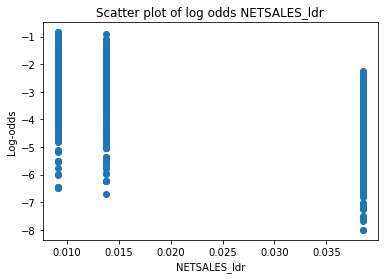

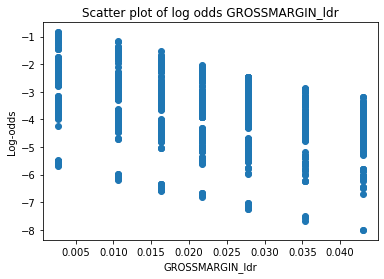

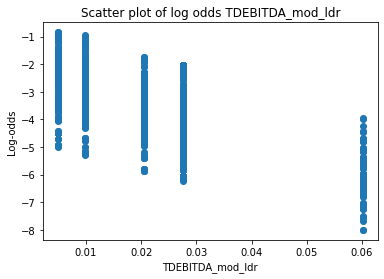

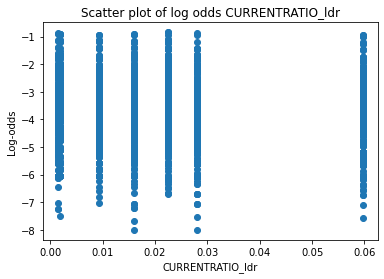

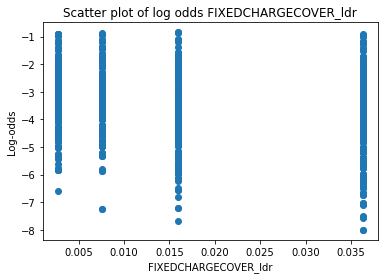

In [10]:
# Visual Check
# Re-run logistic regression on original set of X and y variables


final_model_features= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']
dep_var= ['default_flag3']


X=df_dev[final_model_features]
y=df_dev[dep_var]

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)



logit_results = GLM(y_train, X_train, family=families.Binomial()).fit()
predicted = logit_results.predict(X_train)

# Get log odds values
log_odds = np.log(predicted / (1 - predicted))

for variable in final_model_features:
    plt.scatter(x = X_train[variable].values, y = log_odds)
    plt.xlabel(variable)
    plt.ylabel("Log-odds")
    plt.title("Scatter plot of log odds "+str(variable))
    plt.show()

# Visualize predictor continuous variable vs logit values (Age)
# plt.scatter(x = df_dev['NETSALES_ldr'].values, y = log_odds);
# plt.show()
# Confirming that there is logit linearity for the Age variable 
# (Recall earlier that p value for Age:Log Age is 0.101)

### 2.2.1 Multicolinearity assumption testing : 

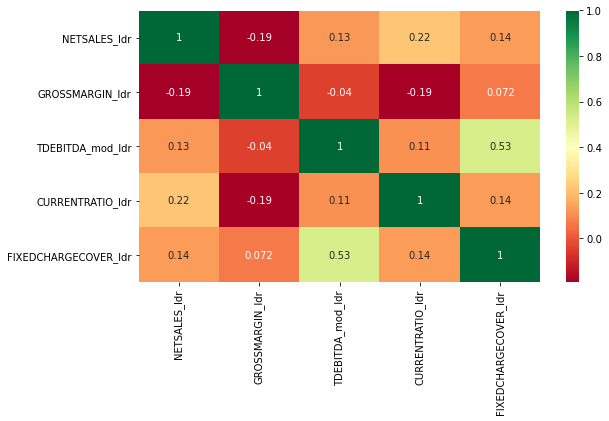

In [11]:
## Heatmap : 

X=df_dev[final_model_features]

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)


corrMatrix = X_train.corr()
plt.subplots(figsize=(9, 5))
sns.heatmap(corrMatrix, annot=True, cmap="RdYlGn")
plt.show()

In [14]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

# Use variance inflation factor to identify any significant multi-collinearity
def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)

display(calc_vif(X_train))
# calc_vif(X_train)


,variables,VIF
0,NETSALES_ldr,3.28
1,GROSSMARGIN_ldr,2.59
2,TDEBITDA_mod_ldr,5.21
3,CURRENTRATIO_ldr,2.22
4,FIXEDCHARGECOVER_ldr,4.67


## Sec 2.2 Create final model using our code: 

Default Rate in training data set :  default_flag3   0.02
dtype: float64
Default Rate in testing data set :  default_flag3   0.02
dtype: float64
Length of training data : 2545.000
Accuracy_Score_Training : 0.979
Recall_Score_Training : 0.000
Precision_Score_Training : 0.000
gini_Score_Training : 0.674473
AUC Training : 0.84
Actual Training Bad Rate : 0.021218
	
Lenght of testing data : 637.000
Accuracy_Score_Testing : 0.980
Recall_Score_Testing : 0.000
Precision_Score_Testing : 0.000
gini_Score_Testing : 0.852811
AUC Testing : 0.93
Actual Testing Bad Rate : 0.020408
Predicted Testing Bad Rate : 0.000000
	
Lenght of OOT data : 456.000
Accuracy_Score_OOT : 0.969
Recall_Score_OOT : 0.000
Precision_Score_OOT : 0.000
gini_Score_OOT : 0.694570
AUC OOT : 0.85
Actual OOT Bad Rate : 0.030702
Predicted OOT Bad Rate : 0.000000
	
Classification  Report : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       624
           1       0.00      0.00  

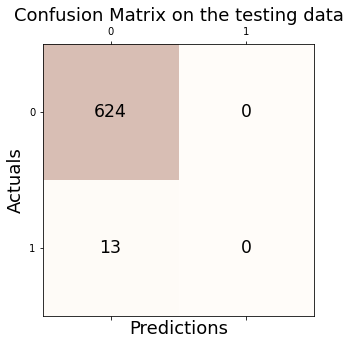

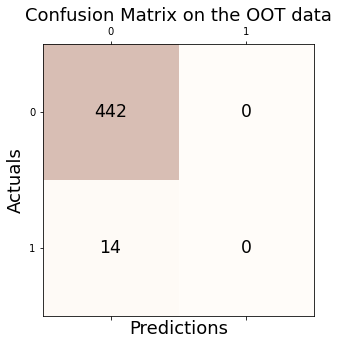

In [9]:
## Create the final model : 
GLOBAL_SEED = 888
pd.options.display.float_format = '{:,.2f}'.format

df_oot = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] >= 2021,:].copy()
df_dev = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] < 2021,:].copy()


final_model_features= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']
dep_var= ['default_flag3']



#=============================================================================================================
#CREATE TRAIN AND TEST SPLIT

random_seed = GLOBAL_SEED

X=df_dev[final_model_features]
y=df_dev[dep_var]

X_oot=df_oot[final_model_features]
y_oot=df_oot[dep_var]

#=============================================================================================================
#FIT LOGISTIC MODEL USING SKLEARN

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)


#=============================================================================================================
## Default rate count: 
print ("Default Rate in training data set : ", y_train.sum()/y_train.count())
print ("Default Rate in testing data set : ", y_test.sum()/y_test.count())



#=============================================================================================================
## Final model performance on training and testing data: 

clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.
model= clf.fit(X_train, y_train)



ypred_train_dt = model.predict(X_train[final_model_features])
ypred_train_proba=model.predict_proba(X_train[final_model_features])[:,1]

ypred_test_dt = model.predict(X_test[final_model_features])
ypred_test_proba=model.predict_proba(X_test[final_model_features])[:,1]

ypred_oot_dt = model.predict(X_oot[final_model_features])
ypred_oot_proba=model.predict_proba(X_oot[final_model_features])[:,1]

Accu_Score_training =accuracy_score(y_train,ypred_train_dt)
Accu_Score_testing =accuracy_score(y_test,ypred_test_dt)
Accu_Score_oot =accuracy_score(y_oot,ypred_oot_dt)

rec_score_training=recall_score(y_train,ypred_train_dt)
rec_score_testing=recall_score(y_test,ypred_test_dt)
rec_score_oot=recall_score(y_oot,ypred_oot_dt)

precsn_score_training=precision_score(y_train, ypred_train_dt)
precsn_score_testing=precision_score(y_test, ypred_test_dt)
precsn_score_oot=precision_score(y_oot, ypred_oot_dt)

auc_training = roc_auc_score(y_train,ypred_train_proba)
gini_training = (2*auc_training -1)

auc_testing = roc_auc_score(y_test,ypred_test_proba)
gini_testing = (2*auc_testing -1)

auc_oot = roc_auc_score(y_oot,ypred_oot_proba)
gini_oot = (2*auc_oot -1)

# F1_score_training = 2 * (precsn_score_training * rec_score_training) / (precsn_score_training + rec_score_training)
# F1_score_testing = 2 * (precsn_score_testing * rec_score_testing) / (precsn_score_testing + rec_score_testing)
# F1_score_oot = 2 * (precsn_score_oot * rec_score_oot) / (precsn_score_oot + rec_score_oot)

Actual_train_bad_rate=y_train.sum()/y_train.count()

Actual_test_bad_rate=y_test.sum()/y_test.count()
predicted_test_bad_rate =ypred_test_dt.sum()/len(ypred_test_dt)

Actual_oot_bad_rate=y_oot.sum()/y_oot.count()
predicted_oot_bad_rate =ypred_oot_dt.sum()/len(ypred_oot_dt)


#=============================================================================================================
## Print Final model performance on training and testing data: 

print("Length of training data : %.3f"  %len(X_train))
print("Accuracy_Score_Training : %.3f"  %Accu_Score_training)
print("Recall_Score_Training : %.3f"  %rec_score_training)
print("Precision_Score_Training : %.3f"  %precsn_score_training)
print("gini_Score_Training : %f"  %gini_training)
print ("AUC Training : %.2f" %auc_training)
print ("Actual Training Bad Rate : %f" %Actual_train_bad_rate)

# print ("F1 Training : %f" %F1_score_training)

print("\t")

print("Lenght of testing data : %.3f"  %len(X_test))
print("Accuracy_Score_Testing : %.3f"  %Accu_Score_testing)
print("Recall_Score_Testing : %.3f"  %rec_score_testing)
print("Precision_Score_Testing : %.3f"  %precsn_score_testing)
print("gini_Score_Testing : %f"  %gini_testing)
print ("AUC Testing : %.2f" %auc_testing)
# print ("F1 Testing : %f" %F1_score_testing)
print ("Actual Testing Bad Rate : %f" %Actual_test_bad_rate)
print ("Predicted Testing Bad Rate : %f" %predicted_test_bad_rate)


print("\t")

print("Lenght of OOT data : %.3f"  %len(X_oot))
print("Accuracy_Score_OOT : %.3f"  %Accu_Score_oot)
print("Recall_Score_OOT : %.3f"  %rec_score_oot)
print("Precision_Score_OOT : %.3f"  %precsn_score_oot)
print("gini_Score_OOT : %f"  %gini_oot)
print ("AUC OOT : %.2f" %auc_oot)
# print ("F1 OOT : %f" %F1_score_oot)
print ("Actual OOT Bad Rate : %f" %Actual_oot_bad_rate)
print ("Predicted OOT Bad Rate : %f" %predicted_oot_bad_rate)


print("\t")


print("Classification  Report : ")
print(classification_report(y_test, ypred_test_dt))

print("\t")

# Calculate the confusion matrix on testing data: 
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=ypred_test_dt)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix on the testing data', fontsize=18)
plt.show()


print("\t")


# Calculate the confusion matrix on OOT data: 
#
conf_matrix = confusion_matrix(y_true=y_oot, y_pred=ypred_oot_dt)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix on the OOT data', fontsize=18)
plt.show()



In [66]:
ypred_train_proba.mean()

0.02121827278264591

In [ ]:
## RBS Segment wise predicted PD :



In [21]:
## Create the final model with train+test vs OOT : 
GLOBAL_SEED = 888
pd.options.display.float_format = '{:,.2f}'.format

df_oot = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] >= 2021,:].copy()
df_dev = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] < 2021,:].copy()


final_model_features= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']
dep_var= ['default_flag3']



#=============================================================================================================
#CREATE TRAIN AND TEST SPLIT

random_seed = GLOBAL_SEED

X_train=df_dev[final_model_features]
y_train=df_dev[dep_var]

X_oot=df_oot[final_model_features]
y_oot=df_oot[dep_var]

#=============================================================================================================



#=============================================================================================================
## Default rate count: 
print ("Default Rate in training data set : ", y_train.sum()/y_train.count())
print ("Default Rate in oot data set : ", y_oot.sum()/y_oot.count())



#=============================================================================================================
## Final model performance on training and testing data: 

clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.
model= clf.fit(X_train, y_train)



ypred_train_dt = model.predict(X_train[final_model_features])
ypred_train_proba=model.predict_proba(X_train[final_model_features])[:,1]



ypred_oot_dt = model.predict(X_oot[final_model_features])
ypred_oot_proba=model.predict_proba(X_oot[final_model_features])[:,1]

auc_training = roc_auc_score(y_train,ypred_train_proba)
gini_training = (2*auc_training -1)



auc_oot = roc_auc_score(y_oot,ypred_oot_proba)
gini_oot = (2*auc_oot -1)




#=============================================================================================================
## Print Final model performance on training and testing data: 


print("gini_Score_Training : %f"  %gini_training)
print ("AUC Training : %.4f" %auc_training)

# print ("F1 Training : %f" %F1_score_training)

print("\t")


print("gini_Score_OOT : %f"  %gini_oot)
print ("AUC OOT : %.4f" %auc_oot)



print("\t")





Default Rate in training data set :  default_flag3   0.02
dtype: float64
Default Rate in oot data set :  default_flag3   0.03
dtype: float64
gini_Score_Training : 0.710371
AUC Training : 0.8552
	
gini_Score_OOT : 0.698125
AUC OOT : 0.8491
	


In [20]:
## Create the final model with whole sample (Train+Test+OOT) : 
GLOBAL_SEED = 888
pd.options.display.float_format = '{:,.2f}'.format

df_dev = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] < 2021,:].copy()


final_model_features= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']
dep_var= ['default_flag3']



#=============================================================================================================
#CREATE TRAIN AND TEST SPLIT

random_seed = GLOBAL_SEED

X_train=final_mdlg_data[final_model_features]
y_train=final_mdlg_data[dep_var]


#=============================================================================================================



#=============================================================================================================
## Default rate count: 
print ("Default Rate in training data set : ", y_train.sum()/y_train.count())



#=============================================================================================================
## Final model performance on training and testing data: 

clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.
model= clf.fit(X_train, y_train)



ypred_train_dt = model.predict(X_train[final_model_features])
ypred_train_proba=model.predict_proba(X_train[final_model_features])[:,1]



auc_training = roc_auc_score(y_train,ypred_train_proba)
gini_training = (2*auc_training -1)




#=============================================================================================================
## Print Final model performance on training and testing data: 


print("gini_Score_Training : %f"  %gini_training)
print ("AUC Training : %.4f" %auc_training)

# print ("F1 Training : %f" %F1_score_training)




print("\t")



print("\t")





Default Rate in training data set :  default_flag3   0.02
dtype: float64
gini_Score_Training : 0.701840
AUC Training : 0.8509
	
	


## Sec 2.3 Determine model coefficients :

In [9]:

coefficients = np.hstack((model.intercept_, model.coef_[0]))
dfm1 = pd.DataFrame(data={'variable': ['intercept'] + final_model_features, 'coefficient': coefficients})

#compute range for each variable
dfrange = pd.DataFrame(columns = ["variable",'Range'])
for var in final_model_features:
    dfrange = dfrange.append({'variable':var, 'Range':X_train[var].max() - X_train[var].min()}, ignore_index=True)
dfm1 = dfm1.merge(dfrange, on='variable')

#compute weights
dfm1 = dfm1.assign(coeftimesrange = dfm1.coefficient*dfm1.Range)
dfm1['weight'] = 100 * dfm1['coeftimesrange'] / dfm1.coeftimesrange.sum()
dfm1.head(10)


,variable,coefficient,Range,coeftimesrange,weight
0,NETSALES_ldr,37.62,0.03,1.10,12.98
1,GROSSMARGIN_ldr,64.80,0.04,2.61,30.68
2,TDEBITDA_mod_ldr,21.11,0.06,1.16,13.69
3,CURRENTRATIO_ldr,40.39,0.06,2.35,27.60
4,FIXEDCHARGECOVER_ldr,38.16,0.03,1.28,15.05


## Sec 2.4 : Segment wise model performance analysis : 

## 2.4.1 : Segment wise model predicetd PD vs actual DR analysis : 

In [14]:
GLOBAL_SEED = 888

pd.options.display.float_format = '{:,.4f}'.format

df_oot = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] >= 2021,:].copy()
df_dev = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] < 2021,:].copy()



final_model_features= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']
segment_info=['rbs_stmtdate','rbs_group']
dep_var= ['default_flag3']

all_vars=final_model_features+segment_info+dep_var
   
RBS_Segments = final_mdlg_data['rbs_stmtdate'].unique().tolist()




#=============================================================================================================
#CREATE TRAIN AND TEST SPLIT

random_seed = GLOBAL_SEED

X_seg=df_dev[final_model_features+segment_info]
y_seg=df_dev[dep_var]



#=============================================================================================================
#FIT LOGISTIC MODEL USING SKLEARN

# split the dataset
X_train_seg, X_test_seg, y_train_seg, y_test_seg = train_test_split(X_seg, y_seg, test_size=0.2, stratify=y, random_state=random_seed)




#=============================================================================================================
## Final model performance on training and testing data: 

clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.
model= clf.fit(X_train_seg[final_model_features], y_train_seg)


X_train_seg['ypred_train_dt'] = model.predict(X_train_seg[final_model_features])
X_train_seg['ypred_train_proba']=model.predict_proba(X_train_seg[final_model_features])[:,1]


x_train_final=pd.concat([X_train_seg,y_train_seg],axis=1)


segment_summary_1=x_train_final.groupby('rbs_stmtdate').agg({'ypred_train_proba':'mean','default_flag3':'mean'}).rename(columns={'ypred_train_proba':'Predicted Mean Probability','default_flag3':'Actual Default Rate'}).reset_index()
display(segment_summary_1)

segment_summary_2=x_train_final.groupby('rbs_group').agg({'ypred_train_proba':'mean','default_flag3':'mean'}).rename(columns={'ypred_train_proba':'Predicted Mean Probability','default_flag3':'Actual Default Rate'}).reset_index()
display(segment_summary_2)

,rbs_stmtdate,Predicted Mean Probability,Actual Default Rate
0,Balance Sheet Dependent,0.0282,0.0232
1,CF - Other,0.0123,0.0096
2,CF - SLBO,0.0272,0.0348
3,ID - Later Stage,0.0340,0.0455


,rbs_group,Predicted Mean Probability,Actual Default Rate
0,BS/ID,0.0295,0.0279
1,CF,0.0173,0.0180


In [ ]:
GLOBAL_SEED = 888

pd.options.display.float_format = '{:,.4f}'.format

df_oot = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] >= 2021,:].copy()
df_dev = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] < 2021,:].copy()



final_model_features= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']
segment_info=['rbs_stmtdate','rbs_group']
dep_var= ['default_flag3']

all_vars=final_model_features+segment_info+dep_var
   
RBS_Segments = final_mdlg_data['rbs_stmtdate'].unique().tolist()




#=============================================================================================================
#CREATE TRAIN AND TEST SPLIT

random_seed = GLOBAL_SEED

X_seg=df_dev[final_model_features+segment_info]
y_seg=df_dev[dep_var]



#=============================================================================================================
#FIT LOGISTIC MODEL USING SKLEARN

# split the dataset
X_train_seg, X_test_seg, y_train_seg, y_test_seg = train_test_split(X_seg, y_seg, test_size=0.2, stratify=y, random_state=random_seed)




#=============================================================================================================
## Final model performance on training and testing data: 

clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.
model= clf.fit(X_train_seg[final_model_features], y_train_seg)


X_train_seg['ypred_train_dt'] = model.predict(X_train_seg[final_model_features])
X_train_seg['ypred_train_proba']=model.predict_proba(X_train_seg[final_model_features])[:,1]


x_train_final=pd.concat([X_train_seg,y_train_seg],axis=1)


segment_summary_1=x_train_final.groupby('rbs_stmtdate').agg({'ypred_train_proba':'mean','default_flag3':'mean'}).rename(columns={'ypred_train_proba':'Predicted Mean Probability','default_flag3':'Actual Default Rate'}).reset_index()
display(segment_summary_1)

segment_summary_2=x_train_final.groupby('rbs_group').agg({'ypred_train_proba':'mean','default_flag3':'mean'}).rename(columns={'ypred_train_proba':'Predicted Mean Probability','default_flag3':'Actual Default Rate'}).reset_index()
display(segment_summary_2)

## 2.4.2 : Segment wise model performance analysis : 

In [14]:
## Segment wise performance analysis keeping X_train and X_Test fixed
GLOBAL_SEED = 888

pd.options.display.float_format = '{:,.4f}'.format

df_oot = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] >= 2021,:].copy()
df_dev = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] < 2021,:].copy()



final_model_features= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']
segment_info=['rbs_stmtdate']
dep_var= ['default_flag3']

all_features=final_model_features+segment_info+dep_var



X=df_dev[all_features]
y=df_dev[dep_var]
        
        

random_seed = GLOBAL_SEED

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=random_seed)

df_seg_perf_total=pd.DataFrame()

def segment_wise_perf_new(segment_name):
    df_seg_perf_total=pd.DataFrame()
    
    RBS_Segments = final_mdlg_data[segment_name].unique().tolist()

    for segment in RBS_Segments:
        
        df_seg_perf=pd.DataFrame()
        
        print(segment)
        
        
        
        data_seg_dev=X_train[X_train[segment_name]==segment].copy()
        X_train_seg=data_seg_dev[final_model_features]
        y_train_seg=data_seg_dev[dep_var]
        
        print("Length of Train data :", len(X_train_seg))
        print("Default in Train data :", (y_train_seg).sum())
            
        
        data_seg_test=X_test[X_test[segment_name]==segment].copy()
        X_test_seg=data_seg_test[final_model_features]
        y_test_seg=data_seg_test[dep_var]
        
        print("Length of Test data :", len(X_test_seg))
        print("Default in Test data :", y_test_seg.sum())
        


        data_seg_oot=df_oot[df_oot[segment_name]==segment].copy()
        X_oot=data_seg_oot[final_model_features]
        y_oot=data_seg_oot[dep_var]
        
        print("Length of OOT data :", len(X_oot))
        print("Default in OOT data :", y_oot.sum())
        


        ypred_train_proba=model.predict_proba(X_train_seg[final_model_features])[:,1]
        ypred_test_proba=model.predict_proba(X_test_seg[final_model_features])[:,1]
        ypred_oot_proba=model.predict_proba(X_oot[final_model_features])[:,1]
        
        auc_training = roc_auc_score(y_train_seg,ypred_train_proba)
        gini_training = (2*auc_training -1)

        auc_testing = roc_auc_score(y_test_seg,ypred_test_proba)
        gini_testing = (2*auc_testing -1)

        auc_oot = roc_auc_score(y_oot,ypred_oot_proba)
        gini_oot = (2*auc_oot -1)

        def_rate_trng= (y_train_seg.sum()/y_train_seg.count())[0]
        def_rate_test= (y_test_seg.sum()/y_test_seg.count())[0]
        def_rate_oot=(y_oot.sum()/y_oot.count())[0]

        df_seg_perf=pd.DataFrame([[segment,def_rate_trng,def_rate_test,def_rate_oot,auc_training,gini_training,auc_testing,
                                               gini_testing,auc_oot,gini_oot]],
                                          columns=['Segment','default_rate_trng','default_rate_test','default_rate_oot','auc_training','gini_training','auc_testing',
                                                   'gini_testing','auc_oot','gini_oot'])

        df_seg_perf_total=df_seg_perf_total.append(df_seg_perf)

    return df_seg_perf_total
    
segment_wise_perf_new('rbs_stmtdate')

Balance Sheet Dependent
Length of Train data : 647
Default in Train data : default_flag3    15
dtype: int64
Length of Test data : 159
Default in Test data : default_flag3    5
dtype: int64
Length of OOT data : 105
Default in OOT data : default_flag3    7
dtype: int64
CF - Other
Length of Train data : 1147
Default in Train data : default_flag3    11
dtype: int64
Length of Test data : 302
Default in Test data : default_flag3    1
dtype: int64
Length of OOT data : 230
Default in OOT data : default_flag3    2
dtype: int64
CF - SLBO
Length of Train data : 575
Default in Train data : default_flag3    20
dtype: int64
Length of Test data : 133
Default in Test data : default_flag3    6
dtype: int64
Length of OOT data : 62
Default in OOT data : default_flag3    2
dtype: int64
ID - Later Stage
Length of Train data : 176
Default in Train data : default_flag3    8
dtype: int64
Length of Test data : 43
Default in Test data : default_flag3    1
dtype: int64
Length of OOT data : 59
Default in OOT data

,Segment,default_rate_trng,default_rate_test,default_rate_oot,auc_training,gini_training,auc_testing,gini_testing,auc_oot,gini_oot
0,Balance Sheet Dependent,0.0232,0.0314,0.0667,0.7485,0.4970,0.9682,0.9364,0.8557,0.7114
0,CF - Other,0.0096,0.0033,0.0087,0.8634,0.7268,0.5814,0.1628,0.7368,0.4737
0,CF - SLBO,0.0348,0.0451,0.0323,0.8230,0.6460,0.9528,0.9055,0.7833,0.5667
0,ID - Later Stage,0.0455,0.0233,0.0508,0.9022,0.8043,0.9524,0.9048,0.8006,0.6012


## Sec 2.4.3 : Chi sq analysis : 

In [19]:
# df_chisq= = df_dev[["rbs_stmtdate","rbs_group","default_flag3","NETSALES_ldr","GROSSMARGIN_ldr","TDEBITDA_mod_ldr","CURRENTRATIO_ldr","FIXEDCHARGECOVER_ldr"]]

import scipy as sc
from scipy.stats import chi2_contingency

final_model_features= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']
segment_info=['rbs_stmtdate','rbs_group']
dep_var= ['default_flag3']


chisq_features=final_model_features+segment_info
X=df_dev[chisq_features]
y=df_dev[dep_var]



# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=GLOBAL_SEED)




chisqt = pd.crosstab(y_train.default_flag3, columns= y_train.default_flag3, margins=True )
print(chisqt)

value = np.array([chisqt.iloc[0][0:3].values,
                  chisqt.iloc[1][0:3].values])


print(chi2_contingency(value)[0:3])

rbs_group      BS/ID    CF   All
default_flag3                   
0                800  1691  2491
1                 23    31    54
All              823  1722  2545
(2.6515158090362543, 0.2656015821471881, 2)


In [20]:
chisqt2 = pd.crosstab(y_train.default_flag3, columns= X_train.rbs_stmtdate, margins=True)
print(chisqt2)

value2 = np.array([chisqt2.iloc[0][0:5].values,
                  chisqt2.iloc[1][0:5].values])
print(chi2_contingency(value2)[0:3])

rbs_stmtdate   Balance Sheet Dependent  CF - Other  CF - SLBO  \
default_flag3                                                   
0                                  632        1136        555   
1                                   15          11         20   
All                                647        1147        575   

rbs_stmtdate   ID - Later Stage   All  
default_flag3                          
0                           168  2491  
1                             8    54  
All                         176  2545  
(17.66016537108273, 0.0014378082983546993, 4)


## Sec 2.4.4 : Include the RBS_Statemtdate and see if those are coming significant or not : 

Default Rate in training data set :  default_flag3   0.02
dtype: float64
Default Rate in testing data set :  default_flag3   0.02
dtype: float64


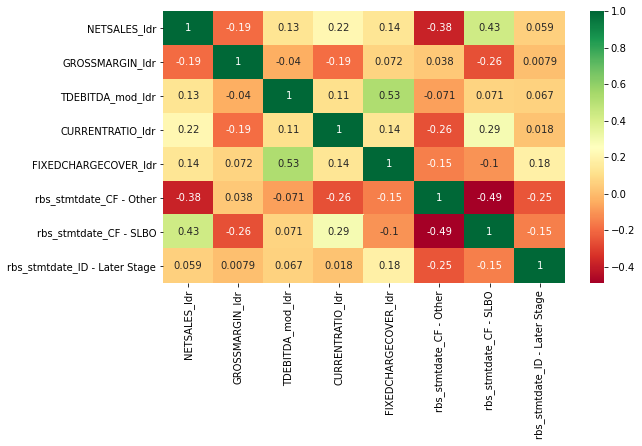

,variables,VIF
0,NETSALES_ldr,4.20
1,GROSSMARGIN_ldr,2.95
2,TDEBITDA_mod_ldr,5.79
3,CURRENTRATIO_ldr,2.36
4,FIXEDCHARGECOVER_ldr,5.07
5,rbs_stmtdate_CF - Other,2.05
6,rbs_stmtdate_CF - SLBO,2.21
7,rbs_stmtdate_ID - Later Stage,1.24


rbs_stmtdate_CF - Other


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          default_flag3   No. Observations:                 2545
Model:                          Logit   Df Residuals:                     2543
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                 0.02820
Time:                        17:32:08   Log-Likelihood:                -254.10
converged:                       True   LL-Null:                       -261.48
Covariance Type:            nonrobust   LLR p-value:                 0.0001227
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.4504      0.155    -22.275      0.000      -3.754      -3.147
rbs_stmtdate_CF - Other    -1.1870      0.340     -3.488      0.000      -1.854      -0.520
===========================================================================================
"""

rbs_stmtdate_CF - SLBO


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          default_flag3   No. Observations:                 2545
Model:                          Logit   Df Residuals:                     2543
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                 0.01122
Time:                        17:32:08   Log-Likelihood:                -258.55
converged:                       True   LL-Null:                       -261.48
Covariance Type:            nonrobust   LLR p-value:                   0.01543
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -4.0420      0.173    -23.365      0.000      -4.381      -3.703
rbs_stmtdate_CF - SLBO     0.7188      0.286      2.514      0.012       0.158       1.279
==========================================================================================
"""

rbs_stmtdate_ID - Later Stage


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          default_flag3   No. Observations:                 2545
Model:                          Logit   Df Residuals:                     2543
Method:                           MLE   Df Model:                            1
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                0.007927
Time:                        17:32:08   Log-Likelihood:                -259.41
converged:                       True   LL-Null:                       -261.48
Covariance Type:            nonrobust   LLR p-value:                   0.04174
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -3.9220      0.149    -26.341      0.000      -4.214      -3.630
rbs_stmtdate_ID - Later Stage     0.8775      0.391      2.242      0.025       0.111       1.644
=================================================================================================
"""

	
Accuracy_Score_Training : 0.979
Recall_Score_Training : 0.000
Precision_Score_Training : 0.000
gini_Score_Training : 0.679349
AUC Training : 0.84
	
Accuracy_Score_Testing : 0.980
Recall_Score_Testing : 0.000
Precision_Score_Testing : 0.000
gini_Score_Testing : 0.869206
AUC Testing : 0.93
Actual Testing Bad Rate : 0.020408
Predicted Testing Bad Rate : 0.000000
	
Accuracy_Score_OOT : 0.969
Recall_Score_OOT : 0.000
Precision_Score_OOT : 0.000
gini_Score_OOT : 0.689884
AUC OOT : 0.84
Actual OOT Bad Rate : 0.030702
Predicted OOT Bad Rate : 0.000000
	
Classification  Report : 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       624
           1       0.00      0.00      0.00        13

    accuracy                           0.98       637
   macro avg       0.49      0.50      0.49       637
weighted avg       0.96      0.98      0.97       637

	


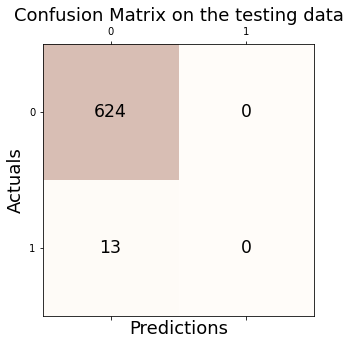

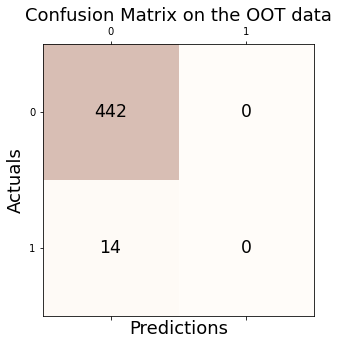

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          default_flag3   No. Observations:                 2545
Model:                          Logit   Df Residuals:                     2536
Method:                           MLE   Df Model:                            8
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                  0.1847
Time:                        17:32:08   Log-Likelihood:                -213.19
converged:                       True   LL-Null:                       -261.48
Covariance Type:            nonrobust   LLR p-value:                 2.123e-17
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -9.3524      0.864    -10.829      0.000     -11.045      -7.660
NETSALES_ldr                     29.9109     12.685      2.358      0.018       5.049      54.773
GROSSMARGIN_ldr                  69.6414     13.596      5.122      0.000      42.993      96.289
TDEBITDA_mod_ldr                 16.4868     12.147      1.357      0.175      -7.321      40.294
CURRENTRATIO_ldr                 37.9797      7.365      5.157      0.000      23.546      52.414
FIXEDCHARGECOVER_ldr             43.2708     16.355      2.646      0.008      11.215      75.327
rbs_stmtdate_CF - Other          -0.0776      0.419     -0.185      0.853      -0.899       0.743
rbs_stmtdate_CF - SLBO            0.6840      0.411      1.662      0.096      -0.122       1.490
rbs_stmtdate_ID - Later Stage     0.5900      0.468      1.259      0.208      -0.328       1.508
=================================================================================================
"""

In [13]:
## Create the final model : 
GLOBAL_SEED = 888
pd.options.display.float_format = '{:,.2f}'.format

df_oot = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] >= 2021,:].copy()
df_dev = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] < 2021,:].copy()


model_features_and_seg_var= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr',
                             'FIXEDCHARGECOVER_ldr','rbs_stmtdate']


dep_var= ['default_flag3']



#=============================================================================================================
#CREATE TRAIN AND TEST SPLIT

random_seed = GLOBAL_SEED

X=df_dev[model_features_and_seg_var]
#encode the data
X_encoded=pd.get_dummies(data=X,drop_first=True)
y=df_dev[dep_var]


X_oot=df_oot[model_features_and_seg_var]
#encode the data
X_oot_encoded=pd.get_dummies(data=X_oot,drop_first=True)
y_oot=df_oot[dep_var]




#=============================================================================================================
#FIT LOGISTIC MODEL USING SKLEARN

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=GLOBAL_SEED)


#=============================================================================================================
## Default rate count: 
print ("Default Rate in training data set : ", y_train.sum()/y_train.count())
print ("Default Rate in testing data set : ", y_test.sum()/y_test.count())



#=============================================================================================================
## Fit the logistic regression : 

clf = LogisticRegression(penalty='none') # logistic regression with no penalty term in the cost function.
model= clf.fit(X_train, y_train)


#=============================================================================================================
## Create a list of final model features including the dummy ones : 


final_model_features=['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr',
                     'rbs_stmtdate_CF - Other','rbs_stmtdate_CF - SLBO','rbs_stmtdate_ID - Later Stage']

#=============================================================================================================
## Check correlation and VIF : 

## Heatmap : 

corrMatrix = X_train.corr()
plt.subplots(figsize=(9, 5))
sns.heatmap(corrMatrix, annot=True, cmap="RdYlGn")
plt.show()

# Use variance inflation factor to identify any significant multi-collinearity
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(df):
    vif = pd.DataFrame()
    vif["variables"] = df.columns
    vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]
    return(vif)

display(calc_vif(X_train))


#=============================================================================================================
## Univariate regression with the segment variables only : 

segment_dummies=['rbs_stmtdate_CF - Other','rbs_stmtdate_CF - SLBO','rbs_stmtdate_ID - Later Stage']

import statsmodels.api as sd


for s in range(len(segment_dummies)):
    segment=segment_dummies[s]
    
    X_train_seg_dummy=X_train[segment].copy()
    
    print(segment)
    
#     clf_segment = LogisticRegression(penalty='none')
#     model_segment= clf_segment.fit(X_train_seg_dummy, y_train)
    
    
    sd_model = sd.Logit(y_train, sm.add_constant(X_train_seg_dummy)).fit(disp=0)
    display(sd_model.summary())

print("\t")
    



#=============================================================================================================
## Final model performance on training and testing data: 

ypred_train_dt = model.predict(X_train[final_model_features])
ypred_train_proba=model.predict_proba(X_train[final_model_features])[:,1]

ypred_test_dt = model.predict(X_test[final_model_features])
ypred_test_proba=model.predict_proba(X_test[final_model_features])[:,1]

ypred_oot_dt = model.predict(X_oot_encoded[final_model_features])
ypred_oot_proba=model.predict_proba(X_oot_encoded[final_model_features])[:,1]

Accu_Score_training =accuracy_score(y_train,ypred_train_dt)
Accu_Score_testing =accuracy_score(y_test,ypred_test_dt)
Accu_Score_oot =accuracy_score(y_oot,ypred_oot_dt)

rec_score_training=recall_score(y_train,ypred_train_dt)
rec_score_testing=recall_score(y_test,ypred_test_dt)
rec_score_oot=recall_score(y_oot,ypred_oot_dt)

precsn_score_training=precision_score(y_train, ypred_train_dt)
precsn_score_testing=precision_score(y_test, ypred_test_dt)
precsn_score_oot=precision_score(y_oot, ypred_oot_dt)

auc_training = roc_auc_score(y_train,ypred_train_proba)
gini_training = (2*auc_training -1)

auc_testing = roc_auc_score(y_test,ypred_test_proba)
gini_testing = (2*auc_testing -1)

auc_oot = roc_auc_score(y_oot,ypred_oot_proba)
gini_oot = (2*auc_oot -1)



Actual_test_bad_rate=y_test.sum()/y_test.count()
predicted_test_bad_rate =ypred_test_dt.sum()/len(ypred_test_dt)

Actual_oot_bad_rate=y_oot.sum()/y_oot.count()
predicted_oot_bad_rate =ypred_oot_dt.sum()/len(ypred_oot_dt)


#=============================================================================================================
## Print Final model performance on training and testing data: 


print("Accuracy_Score_Training : %.3f"  %Accu_Score_training)
print("Recall_Score_Training : %.3f"  %rec_score_training)
print("Precision_Score_Training : %.3f"  %precsn_score_training)
print("gini_Score_Training : %f"  %gini_training)
print ("AUC Training : %.2f" %auc_training)

# print ("F1 Training : %f" %F1_score_training)

print("\t")

print("Accuracy_Score_Testing : %.3f"  %Accu_Score_testing)
print("Recall_Score_Testing : %.3f"  %rec_score_testing)
print("Precision_Score_Testing : %.3f"  %precsn_score_testing)
print("gini_Score_Testing : %f"  %gini_testing)
print ("AUC Testing : %.2f" %auc_testing)
# print ("F1 Testing : %f" %F1_score_testing)
print ("Actual Testing Bad Rate : %f" %Actual_test_bad_rate)
print ("Predicted Testing Bad Rate : %f" %predicted_test_bad_rate)


print("\t")

print("Accuracy_Score_OOT : %.3f"  %Accu_Score_oot)
print("Recall_Score_OOT : %.3f"  %rec_score_oot)
print("Precision_Score_OOT : %.3f"  %precsn_score_oot)
print("gini_Score_OOT : %f"  %gini_oot)
print ("AUC OOT : %.2f" %auc_oot)
# print ("F1 OOT : %f" %F1_score_oot)
print ("Actual OOT Bad Rate : %f" %Actual_oot_bad_rate)
print ("Predicted OOT Bad Rate : %f" %predicted_oot_bad_rate)


print("\t")



#=============================================================================================================
## Classificiation report: 

print("Classification  Report : ")
print(classification_report(y_test, ypred_test_dt))

print("\t")

# Calculate the confusion matrix on testing data: 
#
conf_matrix = confusion_matrix(y_true=y_test, y_pred=ypred_test_dt)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix on the testing data', fontsize=18)
plt.show()


print("\t")


# Calculate the confusion matrix on OOT data: 
#
conf_matrix = confusion_matrix(y_true=y_oot, y_pred=ypred_oot_dt)
#
# Print the confusion matrix using Matplotlib
#
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(conf_matrix, cmap=plt.cm.Oranges, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix on the OOT data', fontsize=18)
plt.show()

#=============================================================================================================
## Determine coefficients and p values using statsmodels package : 

import statsmodels.api as sd
sd_model = sd.Logit(y_train, sm.add_constant(X_train)).fit(disp=0)
display(sd_model.summary())

print("\t")



## Sequentially add the dummies to see if there is any improvement in pseudo Rsq : 

In [41]:
## Create the final model : 
GLOBAL_SEED = 888
pd.options.display.float_format = '{:,.2f}'.format

df_oot = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] >= 2021,:].copy()
df_dev = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] < 2021,:].copy()


model_features_and_seg_var= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr',
                             'FIXEDCHARGECOVER_ldr','rbs_stmtdate']


dep_var= ['default_flag3']



#=============================================================================================================
#CREATE TRAIN AND TEST SPLIT

random_seed = GLOBAL_SEED

X=df_dev[model_features_and_seg_var]
#encode the data
X_encoded=pd.get_dummies(data=X,drop_first=True)
y=df_dev[dep_var]


X_oot=df_oot[model_features_and_seg_var]
#encode the data
X_oot_encoded=pd.get_dummies(data=X_oot,drop_first=True)
y_oot=df_oot[dep_var]




#=============================================================================================================
#FIT LOGISTIC MODEL USING SKLEARN

# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, stratify=y, random_state=GLOBAL_SEED)



final_model_features_with_dummy=['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr',
                     'rbs_stmtdate_CF - Other','rbs_stmtdate_CF - SLBO','rbs_stmtdate_ID - Later Stage']

model_vars=['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']


sd_model = sd.Logit(y_train, sm.add_constant(X_train[model_vars])).fit(disp=0)

print ("Original Model : ")

display(sd_model.summary())

print("\t")


for var_counter in range (len(final_model_features_with_dummy)-3,len(final_model_features_with_dummy)) :
    print(final_model_features[var_counter])
    model_vars.append(final_model_features[var_counter])
    

    #=============================================================================================================
    ## Fit the logistic regression : 

    
    sd_model = sd.Logit(y_train, sm.add_constant(X_train[model_vars])).fit(disp=0)
    display(sd_model.summary())

    print("\t")
    




Original Model : 


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          default_flag3   No. Observations:                 2545
Model:                          Logit   Df Residuals:                     2539
Method:                           MLE   Df Model:                            5
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                  0.1762
Time:                        20:23:01   Log-Likelihood:                -215.40
converged:                       True   LL-Null:                       -261.48
Covariance Type:            nonrobust   LLR p-value:                 2.367e-18
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -9.2289      0.773    -11.938      0.000     -10.744      -7.714
NETSALES_ldr            37.6188     11.759      3.199      0.001      14.571      60.667
GROSSMARGIN_ldr         64.7968     12.909      5.020      0.000      39.496      90.097
TDEBITDA_mod_ldr        21.1106     11.829      1.785      0.074      -2.074      44.296
CURRENTRATIO_ldr        40.3872      7.108      5.682      0.000      26.456      54.318
FIXEDCHARGECOVER_ldr    38.1627     15.375      2.482      0.013       8.028      68.298
========================================================================================
"""

	
rbs_stmtdate_CF - Other


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          default_flag3   No. Observations:                 2545
Model:                          Logit   Df Residuals:                     2538
Method:                           MLE   Df Model:                            6
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                  0.1785
Time:                        20:23:01   Log-Likelihood:                -214.81
converged:                       True   LL-Null:                       -261.48
Covariance Type:            nonrobust   LLR p-value:                 6.137e-18
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -8.9354      0.816    -10.952      0.000     -10.535      -7.336
NETSALES_ldr               34.2029     12.191      2.806      0.005      10.309      58.097
GROSSMARGIN_ldr            63.7825     12.929      4.933      0.000      38.443      89.122
TDEBITDA_mod_ldr           20.0077     11.829      1.691      0.091      -3.178      43.193
CURRENTRATIO_ldr           38.9613      7.246      5.377      0.000      24.760      53.163
FIXEDCHARGECOVER_ldr       38.5846     15.505      2.488      0.013       8.194      68.975
rbs_stmtdate_CF - Other    -0.3886      0.367     -1.060      0.289      -1.107       0.330
===========================================================================================
"""

	
rbs_stmtdate_CF - SLBO


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          default_flag3   No. Observations:                 2545
Model:                          Logit   Df Residuals:                     2537
Method:                           MLE   Df Model:                            7
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                  0.1818
Time:                        20:23:01   Log-Likelihood:                -213.94
converged:                       True   LL-Null:                       -261.48
Covariance Type:            nonrobust   LLR p-value:                 1.113e-17
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -9.2014      0.849    -10.834      0.000     -10.866      -7.537
NETSALES_ldr               30.5392     12.654      2.413      0.016       5.738      55.340
GROSSMARGIN_ldr            68.1438     13.520      5.040      0.000      41.645      94.643
TDEBITDA_mod_ldr           17.0023     12.072      1.408      0.159      -6.659      40.664
CURRENTRATIO_ldr           37.9225      7.360      5.153      0.000      23.498      52.347
FIXEDCHARGECOVER_ldr       44.3364     16.267      2.725      0.006      12.453      76.220
rbs_stmtdate_CF - Other    -0.2419      0.389     -0.622      0.534      -1.004       0.520
rbs_stmtdate_CF - SLBO      0.4983      0.376      1.326      0.185      -0.238       1.235
===========================================================================================
"""

	
rbs_stmtdate_ID - Later Stage


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          default_flag3   No. Observations:                 2545
Model:                          Logit   Df Residuals:                     2536
Method:                           MLE   Df Model:                            8
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                  0.1847
Time:                        20:23:01   Log-Likelihood:                -213.19
converged:                       True   LL-Null:                       -261.48
Covariance Type:            nonrobust   LLR p-value:                 2.123e-17
=================================================================================================
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -9.3524      0.864    -10.829      0.000     -11.045      -7.660
NETSALES_ldr                     29.9109     12.685      2.358      0.018       5.049      54.773
GROSSMARGIN_ldr                  69.6414     13.596      5.122      0.000      42.993      96.289
TDEBITDA_mod_ldr                 16.4868     12.147      1.357      0.175      -7.321      40.294
CURRENTRATIO_ldr                 37.9797      7.365      5.157      0.000      23.546      52.414
FIXEDCHARGECOVER_ldr             43.2708     16.355      2.646      0.008      11.215      75.327
rbs_stmtdate_CF - Other          -0.0776      0.419     -0.185      0.853      -0.899       0.743
rbs_stmtdate_CF - SLBO            0.6840      0.411      1.662      0.096      -0.122       1.490
rbs_stmtdate_ID - Later Stage     0.5900      0.468      1.259      0.208      -0.328       1.508
=================================================================================================
"""

## Sec 2.5  Replicate p -value calculation using sklearn and entire model using statsmodels

In [45]:
import numpy as np
from scipy.stats import norm
from sklearn.linear_model import LogisticRegression

def logit_p1value(model, x):
   
    p1 = model.predict_proba(x)
    n1 = len(p1)
    m1 = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]])
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1))
    answ = np.zeros((m1, m1))
    for i in range(n1):
        answ = answ + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p1[i,1] * p1[i, 0]
    vcov = np.linalg.inv(np.matrix(answ))
    se = np.sqrt(np.diag(vcov))
    t1 =  coefs/se  
    p1 = (1 - norm.cdf(abs(t1))) * 2
    return p1

print(logit_p1value(model, X_train))

import statsmodels.api as sd
sd_model = sd.Logit(y_train, sm.add_constant(X_train)).fit(disp=0)
print(sd_model.pvalues)
sd_model.summary()

[0.00000000e+00 1.37877211e-03 5.17682656e-07 7.43288769e-02
 1.33160689e-08 1.30604412e-02]
const                  0.00
NETSALES_ldr           0.00
GROSSMARGIN_ldr        0.00
TDEBITDA_mod_ldr       0.07
CURRENTRATIO_ldr       0.00
FIXEDCHARGECOVER_ldr   0.01
dtype: float64


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          default_flag3   No. Observations:                 2545
Model:                          Logit   Df Residuals:                     2539
Method:                           MLE   Df Model:                            5
Date:                Thu, 13 Jul 2023   Pseudo R-squ.:                  0.1762
Time:                        13:27:35   Log-Likelihood:                -215.40
converged:                       True   LL-Null:                       -261.48
Covariance Type:            nonrobust   LLR p-value:                 2.367e-18
========================================================================================
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -9.2289      0.773    -11.938      0.000     -10.744      -7.714
NETSALES_ldr            37.6188     11.759      3.199      0.001      14.571      60.667
GROSSMARGIN_ldr         64.7968     12.909      5.020      0.000      39.496      90.097
TDEBITDA_mod_ldr        21.1106     11.829      1.785      0.074      -2.074      44.296
CURRENTRATIO_ldr        40.3872      7.108      5.682      0.000      26.456      54.318
FIXEDCHARGECOVER_ldr    38.1627     15.375      2.482      0.013       8.028      68.298
========================================================================================
"""

As part of the validaiton process we replicated the model in statsmodels package and also we replicated the p value calculation in sklearn. In both the cases, we observe that the starsmodels output is very close to the sklearn ones and similarly the p values obtained from the sklearn package are almost same to the ones as obtained from  statsmodels. 

## Sec 3  Stability Analysis 

## 3.1 Stability analysis Using K-fold cross validation

In [36]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.metrics import accuracy_score


# Import Required Modules.,
from statistics import mean, stdev
from sklearn.model_selection import StratifiedKFold

# Create StratifiedKFold object
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
lst_accu_stratified = []
df_summary=pd.DataFrame()

df_kfold_summary_final=pd.DataFrame()

for i,(train_index, test_index) in enumerate(skf.split(X_train, y_train)):
    x_train_fold, x_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
    
    print("lenght of train fold: ", len(x_train_fold))
    print("lenght of train fold: ", len(x_test_fold))
    

   
    # instantiate the classifier ,
    logistic_clf_kfold = LogisticRegression(penalty='none')
    logistic_clf_kfold.fit(x_train_fold, y_train_fold)

    y_train_fold_proba=logistic_clf_kfold.predict_proba(x_train_fold)
    y_test_fold_proba=logistic_clf_kfold.predict_proba(x_test_fold)

    y_pred_train_fold = logistic_clf_kfold.predict(x_train_fold)
    y_pred_test_fold = logistic_clf_kfold.predict(x_test_fold)

    acc_score_train_fold=accuracy_score(y_train_fold, y_pred_train_fold)
    acc_score_test_fold=accuracy_score(y_test_fold, y_pred_test_fold)
    
    rec_score_train_fold=recall_score(y_train_fold, y_pred_train_fold)
    rec_score_test_fold=recall_score(y_test_fold, y_pred_test_fold)

    precsn_score_train_fold=precision_score(y_train_fold, y_pred_train_fold)
    precsn_score_test_fold=precision_score(y_test_fold, y_pred_test_fold)

    auc_train_fold = roc_auc_score(y_train_fold, y_train_fold_proba[:,1])
    auc_test_fold = roc_auc_score(y_test_fold, y_test_fold_proba[:,1])



    ##Capture rate analysis :

    y_test_proba=pd.Series(y_test_fold_proba[:,1])        

    df_cap_rate=pd.concat([pd.Series(y_test_fold['default_flag3'].values),pd.Series(y_test_proba.values)],axis=1)
    df_cap_rate.columns=['y_test_fold','y_test_proba']
    df_cap_rate_sorted=df_cap_rate.sort_values(by='y_test_proba')

    p_10_prob=df_cap_rate_sorted['y_test_proba'].quantile(0.1)
    p_20_prob=df_cap_rate_sorted['y_test_proba'].quantile(0.2)
    p_30_prob=df_cap_rate_sorted['y_test_proba'].quantile(0.3)

    df_cap_rate_p10=df_cap_rate_sorted[df_cap_rate_sorted['y_test_proba']<p_10_prob]
    df_cap_rate_p20=df_cap_rate_sorted[df_cap_rate_sorted['y_test_proba']<p_20_prob]
    df_cap_rate_p30=df_cap_rate_sorted[df_cap_rate_sorted['y_test_proba']<p_30_prob]

    bads_count_p10=df_cap_rate_p10['y_test_fold'].sum()
    bads_count_p20=df_cap_rate_p20['y_test_fold'].sum()
    bads_count_p30=df_cap_rate_p30['y_test_fold'].sum()

    total_bads=df_cap_rate_sorted['y_test_fold'].sum()

    capture_rate_p10=(bads_count_p10/total_bads)*100
    capture_rate_p20=(bads_count_p20/total_bads)*100
    capture_rate_p30=(bads_count_p30/total_bads)*100


    ## Finally,  bringing it all under a summary table : ,
    df_summary=pd.DataFrame([[i,acc_score_train_fold,acc_score_test_fold,auc_train_fold,auc_test_fold,capture_rate_p10,capture_rate_p20,capture_rate_p30]],columns=['iteration','acc_score_train','acc_score_test','auc_train_fold','auc_test_fold','capture_rate_p10','capture_rate_p20','capture_rate_p30'])
    df_kfold_summary_final=df_kfold_summary_final.append(df_summary)


lenght of train fold:  2036
lenght of train fold:  509
lenght of train fold:  2036
lenght of train fold:  509
lenght of train fold:  2036
lenght of train fold:  509
lenght of train fold:  2036
lenght of train fold:  509
lenght of train fold:  2036
lenght of train fold:  509


In [109]:
df_kfold_summary_final

,iteration,acc_score_train,acc_score_test,auc_train_fold,auc_test_fold,capture_rate_p10,capture_rate_p20,capture_rate_p30
0,0,0.98,0.98,0.86,0.75,0.00,10.00,10.00
0,1,0.98,0.98,0.83,0.85,0.00,0.00,0.00
0,2,0.98,0.98,0.83,0.87,0.00,0.00,0.00
0,3,0.98,0.98,0.87,0.71,0.00,9.09,9.09
0,4,0.98,0.98,0.81,0.94,0.00,0.00,0.00


## 3.2 Stability analysis Using Bootstrapping

### Multiple models on different bootstrapped samples : 

In [6]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import accuracy_score

## Cross tab between rbs_stmtdate and rbs_group
import statsmodels.api as sd



## Create the final model : 
GLOBAL_SEED = 888
pd.options.display.float_format = '{:,.3f}'.format

df_oot = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] >= 2021,:].copy()
df_dev = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] < 2021,:].copy()


final_model_features= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']
dep_var= ['default_flag3']



#=============================================================================================================
#CREATE TRAIN AND TEST SPLIT

# random_seed = GLOBAL_SEED

X=df_dev[final_model_features]
y=df_dev[dep_var]



# split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=GLOBAL_SEED)

bs_perf_summary_total=pd.DataFrame()
BS_summary_total=pd.DataFrame()


# bootstrap predictions

n_iterations = 100
for i in range(n_iterations):
    
    bs_perf_summary=pd.DataFrame()
    
    X_bs, y_bs = resample(X_train, y_train, replace=True)
    
    # instantiate the classifier ,
    logistic_clf_bs = LogisticRegression(penalty='none')
    logistic_clf_bs.fit(X_bs, y_bs)

    y_bs_proba=logistic_clf_bs.predict_proba(X_bs)

    y_pred_bs = logistic_clf_bs.predict(X_bs)

    auc_bs = roc_auc_score(y_bs, y_bs_proba[:,1])
    gini_bs=2*auc_bs-1
    
    count=len(X_bs)
    DR=(y_bs.sum()/count)[0]
    pred_avg_pd=y_bs_proba.mean()
    
    
    ##Check coefficients now : 
    sd_model = sd.Logit(y_bs, sm.add_constant(X_bs)).fit(disp=0)
    results_summary = sd_model.summary()

    results_as_html = results_summary.tables[1].as_html()
    BS_summary_df=pd.read_html(results_as_html, header=0, index_col=0)[0]
    BS_summary_df=BS_summary_df[['coef','P>|z|','std err']].reset_index().rename(columns={'index':'variable','P>|z|':'pvalue','std err':'std_err'}).copy()
    BS_summary_df['Iteration']=i+1
    BS_summary_df['Sample_size']=len(X_bs)

    BS_summary_df['AUC']=auc_bs
    BS_summary_df['Gini']=gini_bs
    BS_summary_df['Defaults']=y_bs.sum()[0]
    BS_summary_df['DR']=BS_summary_df['Defaults']/BS_summary_df['Sample_size']
    
    BS_summary_total=BS_summary_total.append(BS_summary_df)

    
    
    
    
    bs_perf_summary= pd.DataFrame([[i,count,DR,pred_avg_pd,auc_bs,gini_bs]],columns=['Model_no','Sample_size','Def_Rate','Avg_predicted_PD','AUC_Score','Gini_Score'])

    bs_perf_summary_total=bs_perf_summary_total.append(bs_perf_summary)
    
display(bs_perf_summary_total)

display(BS_summary_total)

,Model_no,Sample_size,Def_Rate,Avg_predicted_PD,AUC_Score,Gini_Score
0,0,2545,0.031,0.500,0.864,0.729
0,1,2545,0.018,0.500,0.775,0.550
0,2,2545,0.024,0.500,0.816,0.632
0,3,2545,0.028,0.500,0.847,0.694
0,4,2545,0.019,0.500,0.830,0.659
...,...,...,...,...,...,...
0,95,2545,0.021,0.500,0.857,0.714
0,96,2545,0.020,0.500,0.881,0.762
0,97,2545,0.024,0.500,0.815,0.630
0,98,2545,0.028,0.500,0.830,0.660


,variable,coef,pvalue,std_err,Iteration,Sample_size,AUC,Gini,Defaults,DR
0,const,-9.669,0.000,0.724,1,2545,0.864,0.729,78,0.031
1,NETSALES_ldr,28.737,0.003,9.792,1,2545,0.864,0.729,78,0.031
2,GROSSMARGIN_ldr,83.428,0.000,11.803,1,2545,0.864,0.729,78,0.031
3,TDEBITDA_mod_ldr,24.645,0.017,10.322,1,2545,0.864,0.729,78,0.031
4,CURRENTRATIO_ldr,49.091,0.000,6.254,1,2545,0.864,0.729,78,0.031
...,...,...,...,...,...,...,...,...,...,...
1,NETSALES_ldr,24.445,0.050,12.460,100,2545,0.794,0.588,44,0.017
2,GROSSMARGIN_ldr,51.655,0.000,13.970,100,2545,0.794,0.588,44,0.017
3,TDEBITDA_mod_ldr,1.266,0.932,14.863,100,2545,0.794,0.588,44,0.017
4,CURRENTRATIO_ldr,39.163,0.000,7.866,100,2545,0.794,0.588,44,0.017


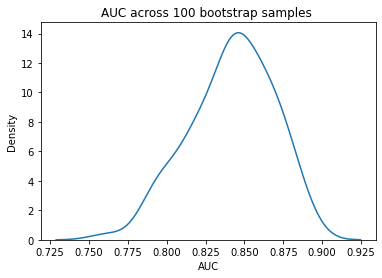

In [93]:
import seaborn as sns
# plot distribution of accuracy
sns.kdeplot(bs_perf_summary_total['AUC_Score'])
plt.title("AUC across 100 bootstrap samples ")
plt.xlabel("AUC")
plt.show()

Bootstrapped model Stability Analysis distribution of coefficients : 


,variable,coef,pvalue,std_err,Iteration,Sample_size,AUC,Gini,Defaults,DR
1,NETSALES_ldr,14.971,0.182,11.220,1,2545,0.795,0.591,51,0.020
1,NETSALES_ldr,28.749,0.022,12.525,2,2545,0.859,0.719,46,0.018
1,NETSALES_ldr,35.789,0.006,13.080,3,2545,0.842,0.683,42,0.017
1,NETSALES_ldr,36.271,0.004,12.535,4,2545,0.836,0.673,48,0.019
1,NETSALES_ldr,41.935,0.000,11.850,5,2545,0.846,0.692,55,0.022
...,...,...,...,...,...,...,...,...,...,...
1,NETSALES_ldr,56.733,0.000,12.951,96,2545,0.835,0.669,52,0.020
1,NETSALES_ldr,34.944,0.002,11.273,97,2545,0.813,0.626,55,0.022
1,NETSALES_ldr,58.005,0.000,14.362,98,2545,0.803,0.606,48,0.019
1,NETSALES_ldr,29.235,0.010,11.404,99,2545,0.848,0.696,53,0.021


Distribution of coeffcients for variable :NETSALES_ldr


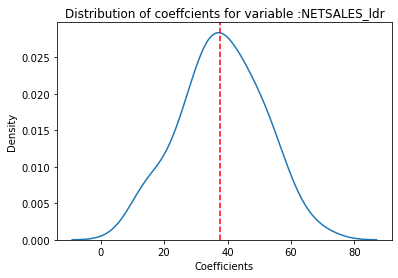

,variable,coef,pvalue,std_err,Iteration,Sample_size,AUC,Gini,Defaults,DR
2,GROSSMARGIN_ldr,58.281,0.000,13.200,1,2545,0.795,0.591,51,0.020
2,GROSSMARGIN_ldr,61.749,0.000,14.037,2,2545,0.859,0.719,46,0.018
2,GROSSMARGIN_ldr,79.734,0.000,15.023,3,2545,0.842,0.683,42,0.017
2,GROSSMARGIN_ldr,61.393,0.000,13.417,4,2545,0.836,0.673,48,0.019
2,GROSSMARGIN_ldr,65.314,0.000,12.791,5,2545,0.846,0.692,55,0.022
...,...,...,...,...,...,...,...,...,...,...
2,GROSSMARGIN_ldr,61.243,0.000,12.880,96,2545,0.835,0.669,52,0.020
2,GROSSMARGIN_ldr,50.806,0.000,12.539,97,2545,0.813,0.626,55,0.022
2,GROSSMARGIN_ldr,29.601,0.019,12.570,98,2545,0.803,0.606,48,0.019
2,GROSSMARGIN_ldr,70.895,0.000,13.572,99,2545,0.848,0.696,53,0.021


Distribution of coeffcients for variable :GROSSMARGIN_ldr


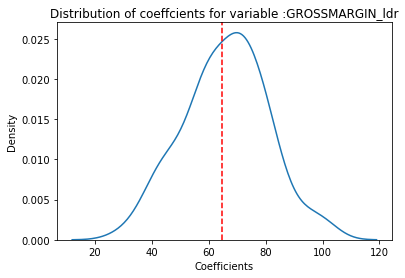

,variable,coef,pvalue,std_err,Iteration,Sample_size,AUC,Gini,Defaults,DR
3,TDEBITDA_mod_ldr,17.658,0.163,12.658,1,2545,0.795,0.591,51,0.020
3,TDEBITDA_mod_ldr,32.622,0.004,11.226,2,2545,0.859,0.719,46,0.018
3,TDEBITDA_mod_ldr,15.565,0.226,12.859,3,2545,0.842,0.683,42,0.017
3,TDEBITDA_mod_ldr,16.603,0.199,12.914,4,2545,0.836,0.673,48,0.019
3,TDEBITDA_mod_ldr,14.409,0.244,12.374,5,2545,0.846,0.692,55,0.022
...,...,...,...,...,...,...,...,...,...,...
3,TDEBITDA_mod_ldr,-6.224,0.687,15.466,96,2545,0.835,0.669,52,0.020
3,TDEBITDA_mod_ldr,10.261,0.435,13.136,97,2545,0.813,0.626,55,0.022
3,TDEBITDA_mod_ldr,28.867,0.008,10.913,98,2545,0.803,0.606,48,0.019
3,TDEBITDA_mod_ldr,32.559,0.004,11.256,99,2545,0.848,0.696,53,0.021


Distribution of coeffcients for variable :TDEBITDA_mod_ldr


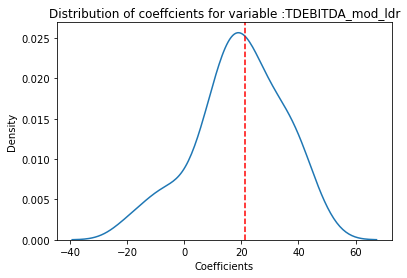

,variable,coef,pvalue,std_err,Iteration,Sample_size,AUC,Gini,Defaults,DR
4,CURRENTRATIO_ldr,38.715,0.000,7.196,1,2545,0.795,0.591,51,0.020
4,CURRENTRATIO_ldr,49.260,0.000,7.963,2,2545,0.859,0.719,46,0.018
4,CURRENTRATIO_ldr,45.546,0.000,8.054,3,2545,0.842,0.683,42,0.017
4,CURRENTRATIO_ldr,38.441,0.000,7.470,4,2545,0.836,0.673,48,0.019
4,CURRENTRATIO_ldr,46.021,0.000,7.075,5,2545,0.846,0.692,55,0.022
...,...,...,...,...,...,...,...,...,...,...
4,CURRENTRATIO_ldr,42.655,0.000,7.196,96,2545,0.835,0.669,52,0.020
4,CURRENTRATIO_ldr,35.128,0.000,6.881,97,2545,0.813,0.626,55,0.022
4,CURRENTRATIO_ldr,21.672,0.003,7.361,98,2545,0.803,0.606,48,0.019
4,CURRENTRATIO_ldr,46.827,0.000,7.037,99,2545,0.848,0.696,53,0.021


Distribution of coeffcients for variable :CURRENTRATIO_ldr


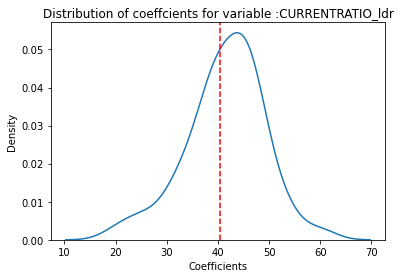

,variable,coef,pvalue,std_err,Iteration,Sample_size,AUC,Gini,Defaults,DR
5,FIXEDCHARGECOVER_ldr,35.557,0.014,14.456,1,2545,0.795,0.591,51,0.020
5,FIXEDCHARGECOVER_ldr,33.897,0.046,16.984,2,2545,0.859,0.719,46,0.018
5,FIXEDCHARGECOVER_ldr,34.335,0.037,16.427,3,2545,0.842,0.683,42,0.017
5,FIXEDCHARGECOVER_ldr,42.244,0.012,16.902,4,2545,0.836,0.673,48,0.019
5,FIXEDCHARGECOVER_ldr,43.383,0.005,15.416,5,2545,0.846,0.692,55,0.022
...,...,...,...,...,...,...,...,...,...,...
5,FIXEDCHARGECOVER_ldr,32.756,0.028,14.943,96,2545,0.835,0.669,52,0.020
5,FIXEDCHARGECOVER_ldr,30.427,0.030,14.033,97,2545,0.813,0.626,55,0.022
5,FIXEDCHARGECOVER_ldr,28.411,0.059,15.021,98,2545,0.803,0.606,48,0.019
5,FIXEDCHARGECOVER_ldr,23.729,0.098,14.353,99,2545,0.848,0.696,53,0.021


Distribution of coeffcients for variable :FIXEDCHARGECOVER_ldr


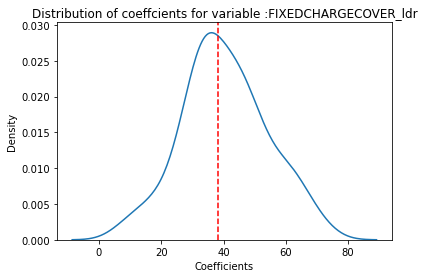

In [94]:
## Plot :
import matplotlib.pyplot as plt
import seaborn as sns

final_model_features = ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']

orig_coef_values = [37.6188,64.7968,21.1106,40.3872,38.1627]

print("Bootstrapped model Stability Analysis distribution of coefficients : ")

for i in range (len(final_model_features)):
    variable=final_model_features[i]
    df_var=BS_summary_total[BS_summary_total['variable']==variable]
    orig_value=orig_coef_values[i]
    display(df_var)
    # plot distribution of coefficient
    print("Distribution of coeffcients for variable :{}".format(variable))
    
    sns.kdeplot(df_var['coef'])
    plt.axvline(x=orig_value, color='r', linestyle='dashed')
    plt.title("Distribution of coeffcients for variable :{}".format(variable))
    plt.xlabel("Coefficients")
    plt.show()

Distribution of difference in original vs boostrapped coeffcients for variable :NETSALES_ldr


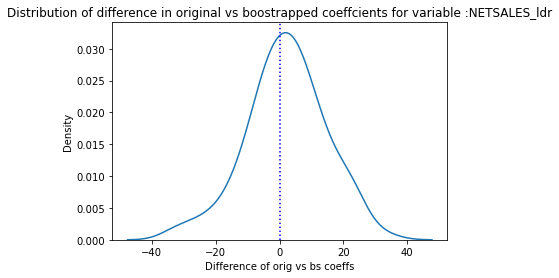



Boxplot of difference in original vs boostrapped coeffcients for variable :NETSALES_ldr




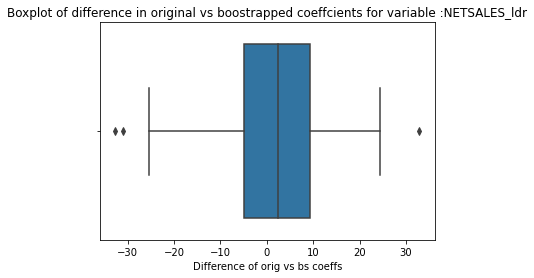

Distribution of difference in original vs boostrapped coeffcients for variable :GROSSMARGIN_ldr


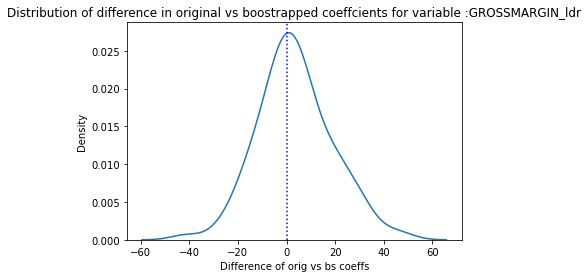



Boxplot of difference in original vs boostrapped coeffcients for variable :GROSSMARGIN_ldr




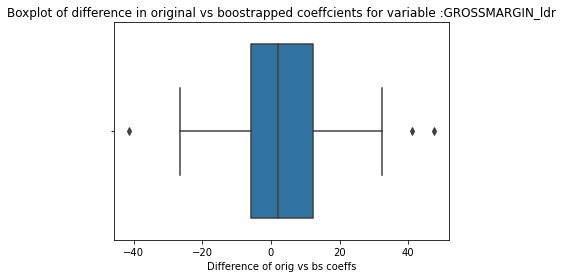

Distribution of difference in original vs boostrapped coeffcients for variable :TDEBITDA_mod_ldr


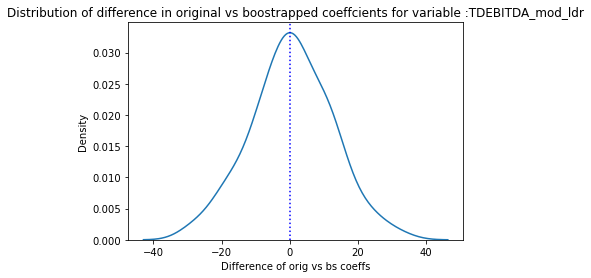



Boxplot of difference in original vs boostrapped coeffcients for variable :TDEBITDA_mod_ldr




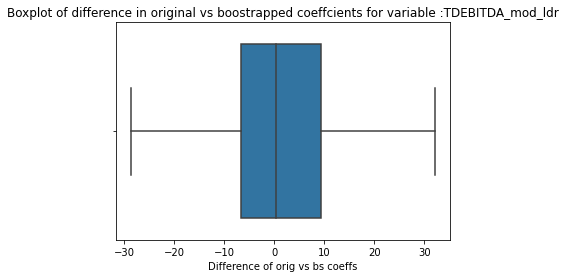

Distribution of difference in original vs boostrapped coeffcients for variable :CURRENTRATIO_ldr


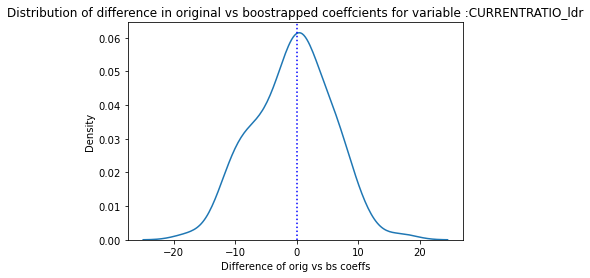



Boxplot of difference in original vs boostrapped coeffcients for variable :CURRENTRATIO_ldr




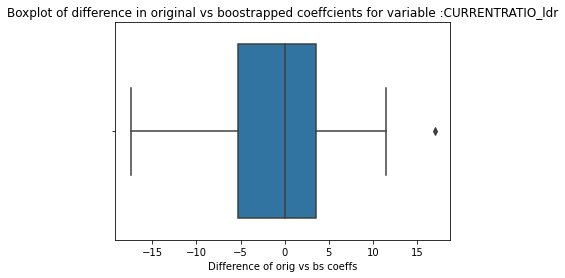

Distribution of difference in original vs boostrapped coeffcients for variable :FIXEDCHARGECOVER_ldr


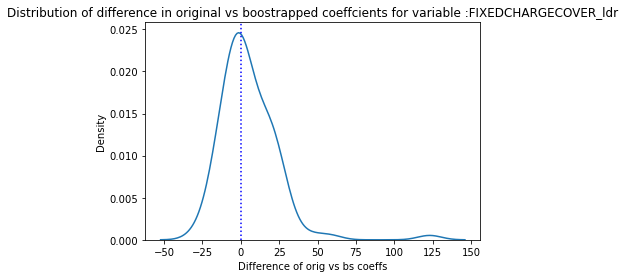



Boxplot of difference in original vs boostrapped coeffcients for variable :FIXEDCHARGECOVER_ldr




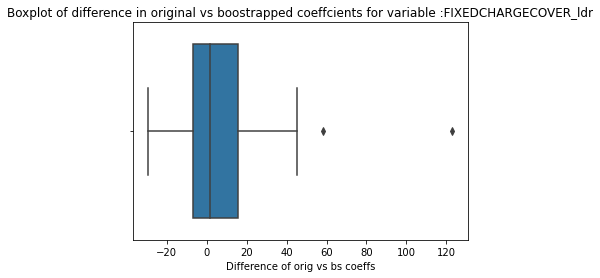

,sl_no,variable,orig_value,mean_bs_coef,std_dev_bs_coef,mean_bs_coef_diff,std_dev_bs_coef_diff
0,0,NETSALES_ldr,37.619,39.675,12.442,2.057,12.442
0,1,GROSSMARGIN_ldr,64.797,68.342,15.276,3.545,15.276
0,2,TDEBITDA_mod_ldr,21.111,21.650,11.929,0.540,11.929
0,3,CURRENTRATIO_ldr,40.387,39.681,6.295,-0.707,6.295
0,4,FIXEDCHARGECOVER_ldr,38.163,43.428,19.247,5.266,19.247


In [85]:
import statistics as st

final_model_features = ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']

orig_coef_values = [37.6188,64.7968,21.1106,40.3872,38.1627]

df_coef_diff_summary_total=pd.DataFrame()

for i in range (len(final_model_features)):
    df_coef_diff_summary=pd.DataFrame()
    
    
    variable=final_model_features[i]
    df_var=BS_summary_total[BS_summary_total['variable']==variable]
    orig_value=orig_coef_values[i]
    df_var['orig_value']=orig_coef_values[i]
    df_var['difference']=df_var['coef']- df_var['orig_value']
    
    print("Distribution of difference in original vs boostrapped coeffcients for variable :{}".format(variable))
    
    sns.kdeplot(df_var['difference'])
    plt.axvline(x=0, color='b', linestyle='dotted')
    plt.title("Distribution of difference in original vs boostrapped coeffcients for variable :{}".format(variable))
    plt.xlabel("Difference of orig vs bs coeffs")
    plt.show()
    
    print("\n")
    
    print("Boxplot of difference in original vs boostrapped coeffcients for variable :{}".format(variable))
    print("\n")

    sns.boxplot(data=df_var,x=df_var['difference'])
    plt.title("Boxplot of difference in original vs boostrapped coeffcients for variable :{}".format(variable))
    plt.xlabel("Difference of orig vs bs coeffs")
    plt.show()
    
    
    mean_coef=df_var['coef'].mean()
    std_dev_coef=st.stdev(df_var['coef'])
    
    
    mean_coef_diff=df_var['difference'].mean()
    std_dev_coef_diff=st.stdev(df_var['difference'])
    
    df_coef_diff_summary=pd.DataFrame([[i,variable,orig_value,mean_coef,std_dev_coef,mean_coef_diff,std_dev_coef_diff]],columns=['sl_no','variable','orig_value','mean_bs_coef','std_dev_bs_coef','mean_bs_coef_diff','std_dev_bs_coef_diff'])
    
    df_coef_diff_summary_total=df_coef_diff_summary_total.append(df_coef_diff_summary)

df_coef_diff_summary_total

Distribution of std error of the boostrapped coeffcients for variable :NETSALES_ldr


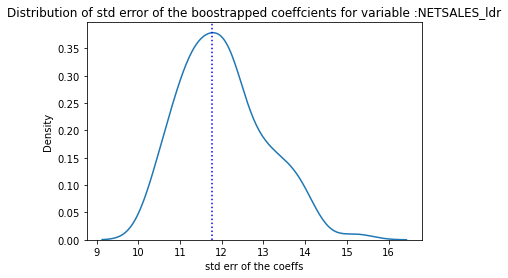

Distribution of std error of the boostrapped coeffcients for variable :GROSSMARGIN_ldr


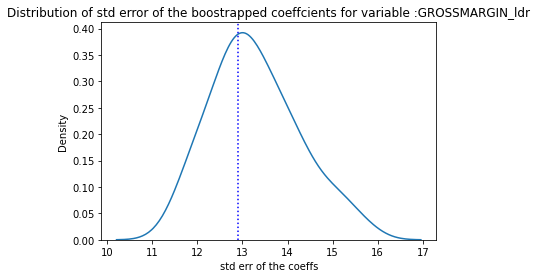

Distribution of std error of the boostrapped coeffcients for variable :TDEBITDA_mod_ldr


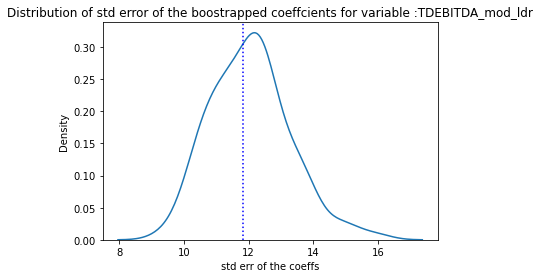

Distribution of std error of the boostrapped coeffcients for variable :CURRENTRATIO_ldr


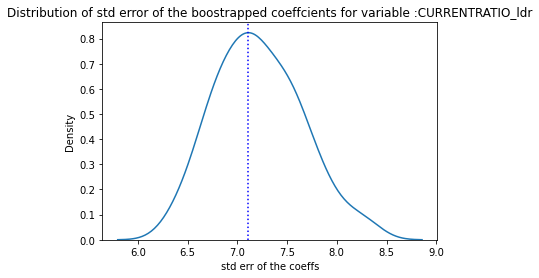

Distribution of std error of the boostrapped coeffcients for variable :FIXEDCHARGECOVER_ldr


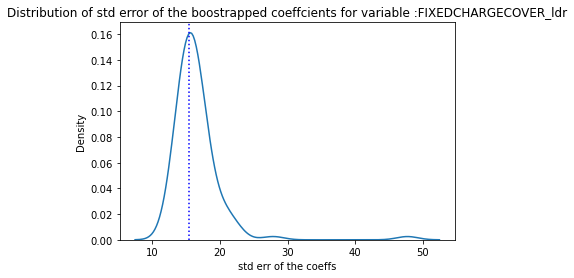

,sl_no,variable,orig_value,mean_std_err,mean_std_err_difference
0,0,NETSALES_ldr,11.759,12.024,0.265
0,1,GROSSMARGIN_ldr,12.909,13.279,0.370
0,2,TDEBITDA_mod_ldr,11.829,12.051,0.222
0,3,CURRENTRATIO_ldr,7.108,7.214,0.106
0,4,FIXEDCHARGECOVER_ldr,15.375,16.549,1.174


In [82]:
## Distribution of the std errors of the coeffs : 

final_model_features = ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']

orig_std_err_values = [11.759,12.909,11.829,7.108,15.375]

df_std_err_diff_summary_total=pd.DataFrame()

for i in range (len(final_model_features)):
    df_std_err_diff_summary=pd.DataFrame()
    
    
    variable=final_model_features[i]
    df_var=BS_summary_total[BS_summary_total['variable']==variable]
    orig_std_err_value=orig_std_err_values[i]
    df_var['orig_std_err_value']=orig_std_err_values[i]
    df_var['difference_std_err']=df_var['std_err']- df_var['orig_std_err_value']
    
    print("Distribution of std error of the boostrapped coeffcients for variable :{}".format(variable))
    
    sns.kdeplot(df_var['std_err'])
    plt.axvline(x=orig_std_err_value, color='b', linestyle='dotted')
    plt.title("Distribution of std error of the boostrapped coeffcients for variable :{}".format(variable))
    plt.xlabel("std err of the coeffs")
    plt.show()
    
#     print("\n")
    
#     print("Boxplot of difference in original vs boostrapped coeffcients for variable :{}".format(variable))
#     print("\n")

#     sns.boxplot(data=df_var,x=df_var['difference'])
#     plt.title("Boxplot of difference in original vs boostrapped coeffcients for variable :{}".format(variable))
#     plt.xlabel("Difference of orig vs bs coeffs")
#     plt.show()
    
    
    mean_std_err=df_var['std_err'].mean()
          
    mean_std_err_diff=df_var['difference_std_err'].mean()

    
    
    df_std_err_diff_summary=pd.DataFrame([[i,variable,orig_std_err_value,mean_std_err,mean_std_err_diff]],columns=['sl_no','variable','orig_value','mean_std_err','mean_std_err_difference'])
    
    df_std_err_diff_summary_total=df_std_err_diff_summary_total.append(df_std_err_diff_summary)

df_std_err_diff_summary_total

In [59]:
## Report avg AUC, predicted PD and Gini :

print ("avg AUC of the bootstrapped models : ", bs_perf_summary_total['AUC_Score'].mean())
print ("avg Gini of the bootstrapped models : ", bs_perf_summary_total['Gini_Score'].mean())
print ("avg DR of the bootstrapped models : ", bs_perf_summary_total['Def_Rate'].mean())
print ("avg predicted PD of the bootstrapped models : ", bs_perf_summary_total['Avg_predicted_PD'].mean())


avg AUC of the bootstrapped models :  0.8426131147552741
avg Gini of the bootstrapped models :  0.6852262295105472
avg DR of the bootstrapped models :  0.021084479371316304
avg predicted PD of the bootstrapped models :  0.5


## Stability analysis with varying time line : 

In [65]:
df_dev.groupby('STATEMENTYEAR').agg({'default_flag3':'sum'})

,default_flag3
STATEMENTYEAR,
"2,007.00",0
"2,008.00",3
"2,009.00",0
"2,010.00",0
"2,011.00",4
"2,012.00",1
"2,013.00",5
"2,014.00",7
"2,015.00",12


In [19]:
## Forward stability analysis :

## Cross tab between rbs_stmtdate and rbs_group
import statsmodels.api as sd


year_list=df_dev['STATEMENTYEAR'].unique().tolist()
year_list.sort()

df_fwd_dev=pd.DataFrame()

final_model_features= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']
segment_info=['rbs_stmtdate','rbs_group']
dep_var= ['default_flag3']
orignial_year=['STATEMENTYEAR']


final_var_list=final_model_features+dep_var+orignial_year


df_dev_stablty=df_dev[final_var_list].copy()
cum_year_list=[]
all_model_summarry_df=pd.DataFrame()

## Since there are no defaults for 2007,2009 and 2010 : we assume all the records till 2010 as 2010 only.
df_dev_stablty['Updated_STATEMENTYEAR'] = np.where(df_dev_stablty['STATEMENTYEAR']<= 2010, 2010,df_dev_stablty['STATEMENTYEAR'] )
year_updated=['Updated_STATEMENTYEAR']

final_var_list=final_model_features+dep_var+year_updated

model_summary_df=pd.DataFrame()

year_list_new=df_dev_stablty['Updated_STATEMENTYEAR'].unique().tolist()
year_list_new.sort()

for i in range (len(year_list_new)):
    
    year=year_list_new[i]
    cum_year_list.append(year)
    
    dev_data_year=df_dev_stablty[df_dev_stablty['Updated_STATEMENTYEAR']==year]
    df_fwd_dev=pd.concat([df_fwd_dev, dev_data_year], axis=0)  # row wise stacking
    
    X_stablty=df_fwd_dev[final_model_features].copy()
    y_stablty=df_fwd_dev[dep_var].copy()
    
    # instantiate the classifier ,
    logistic_clf = LogisticRegression(penalty='none')
    model_stablty=logistic_clf.fit(X_stablty, y_stablty)

    y_stablty_proba=model_stablty.predict_proba(X_stablty)

    auc_stablty = roc_auc_score(y_stablty, y_stablty_proba[:,1])
    gini_stablty= 2*auc_stablty-1
    
    
    sd_model = sd.Logit(y_stablty, sm.add_constant(X_stablty)).fit(disp=0)
    results_summary = sd_model.summary()

    results_as_html = results_summary.tables[1].as_html()
    model_summary_df=pd.read_html(results_as_html, header=0, index_col=0)[0]
    model_summary_df=model_summary_df[['coef','P>|z|']].reset_index().rename(columns={'index':'variable','P>|z|':'pvalue'}).copy()
    model_summary_df['Iteration']=i+1
    model_summary_df['Year']=year
    model_summary_df['data_length']=len(dev_data_year)
    model_summary_df['cumulative_length']=len(df_fwd_dev)
    model_summary_df['AUC']=auc_stablty
    model_summary_df['Gini']=gini_stablty
    model_summary_df['Defaults']=dev_data_year[dep_var].sum()[0]
    model_summary_df['Cumulative_Defaults']=df_fwd_dev[dep_var].sum()[0]
    model_summary_df['DR']=model_summary_df['Defaults']/model_summary_df['data_length']
    model_summary_df['Culumative_DR']=model_summary_df['Cumulative_Defaults']/model_summary_df['cumulative_length']
    
    
    
#     model_summary_df.at['Cumulative_Years']=cum_year_list
    
    all_model_summarry_df=all_model_summarry_df.append(model_summary_df)
    
    
#     df.at[1, 'Duration']

all_model_summarry_df
    

    

,variable,coef,pvalue,Iteration,Year,data_length,cumulative_length,AUC,Gini,Defaults,Cumulative_Defaults,DR,Culumative_DR
0,const,-10.20,0.00,1,"2,010.00",462,462,0.77,0.53,3,3,0.01,0.01
1,NETSALES_ldr,-56.54,0.34,1,"2,010.00",462,462,0.77,0.53,3,3,0.01,0.01
2,GROSSMARGIN_ldr,94.07,0.18,1,"2,010.00",462,462,0.77,0.53,3,3,0.01,0.01
3,TDEBITDA_mod_ldr,60.04,0.16,1,"2,010.00",462,462,0.77,0.53,3,3,0.01,0.01
4,CURRENTRATIO_ldr,60.34,0.07,1,"2,010.00",462,462,0.77,0.53,3,3,0.01,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,NETSALES_ldr,44.83,0.00,11,"2,020.00",355,3182,0.86,0.71,6,67,0.02,0.02
2,GROSSMARGIN_ldr,73.00,0.00,11,"2,020.00",355,3182,0.86,0.71,6,67,0.02,0.02
3,TDEBITDA_mod_ldr,19.89,0.06,11,"2,020.00",355,3182,0.86,0.71,6,67,0.02,0.02
4,CURRENTRATIO_ldr,42.86,0.00,11,"2,020.00",355,3182,0.86,0.71,6,67,0.02,0.02


In [131]:
y_train.sum()[0]

54

In [22]:
## Just select model performance :

model_perf_summary = all_model_summarry_df[['Year','Iteration','pvalue','data_length','cumulative_length',
                                            'Defaults','DR','Cumulative_Defaults','Culumative_DR','AUC','Gini']]
model_perf_summary=model_perf_summary.groupby('Year').agg({'Iteration':'mean','pvalue':'max','data_length':'mean',
                                        'cumulative_length':'mean','Defaults':'mean','DR':'mean','Cumulative_Defaults':'mean',
                                                           'Culumative_DR':'mean','AUC':'mean','Gini':'mean'})

model_perf_summary.rename(columns={'pvalue':'max_pvalue'}).reset_index()




,Year,Iteration,max_pvalue,data_length,cumulative_length,Defaults,DR,Cumulative_Defaults,Culumative_DR,AUC,Gini
0,"2,010.00",1,0.78,462,462,3,0.01,3,0.01,0.77,0.53
1,"2,011.00",2,0.84,162,624,4,0.02,7,0.01,0.83,0.66
2,"2,012.00",3,0.70,193,817,1,0.01,8,0.01,0.85,0.69
3,"2,013.00",4,0.91,221,1038,5,0.02,13,0.01,0.80,0.61
4,"2,014.00",5,0.69,264,1302,7,0.03,20,0.02,0.81,0.62
5,"2,015.00",6,0.13,294,1596,12,0.04,32,0.02,0.83,0.66
6,"2,016.00",7,0.06,294,1890,6,0.02,38,0.02,0.84,0.68
7,"2,017.00",8,0.08,297,2187,6,0.02,44,0.02,0.84,0.67
8,"2,018.00",9,0.03,304,2491,7,0.02,51,0.02,0.84,0.68
9,"2,019.00",10,0.06,336,2827,10,0.03,61,0.02,0.85,0.70


Forward Stability Analysis : 


,variable,coef,pvalue,Iteration,Year,data_length,cumulative_length,AUC,Gini,Defaults,Cumulative_Defaults,DR,Culumative_DR
1,NETSALES_ldr,-56.54,0.34,1,"2,010.00",462,462,0.77,0.53,3,3,0.01,0.01
1,NETSALES_ldr,-6.43,0.84,2,"2,011.00",162,624,0.83,0.66,4,7,0.02,0.01
1,NETSALES_ldr,-11.64,0.70,3,"2,012.00",193,817,0.85,0.69,1,8,0.01,0.01
1,NETSALES_ldr,-2.55,0.91,4,"2,013.00",221,1038,0.80,0.61,5,13,0.02,0.01
1,NETSALES_ldr,7.43,0.69,5,"2,014.00",264,1302,0.81,0.62,7,20,0.03,0.02
1,NETSALES_ldr,22.68,0.13,6,"2,015.00",294,1596,0.83,0.66,12,32,0.04,0.02
1,NETSALES_ldr,32.02,0.02,7,"2,016.00",294,1890,0.84,0.68,6,38,0.02,0.02
1,NETSALES_ldr,32.06,0.01,8,"2,017.00",297,2187,0.84,0.67,6,44,0.02,0.02
1,NETSALES_ldr,30.71,0.01,9,"2,018.00",304,2491,0.84,0.68,7,51,0.02,0.02
1,NETSALES_ldr,41.12,0.00,10,"2,019.00",336,2827,0.85,0.70,10,61,0.03,0.02


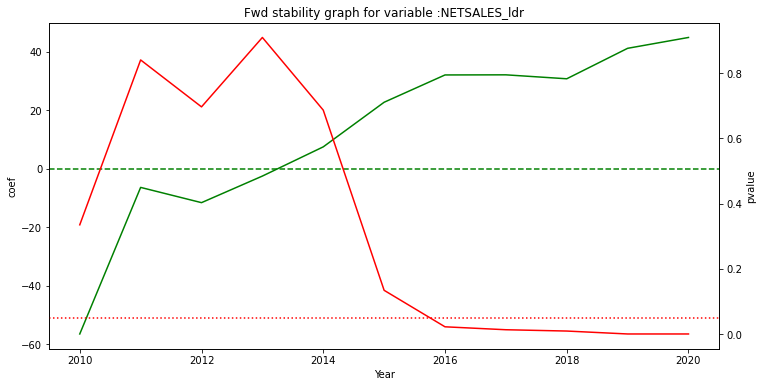

,variable,coef,pvalue,Iteration,Year,data_length,cumulative_length,AUC,Gini,Defaults,Cumulative_Defaults,DR,Culumative_DR
2,GROSSMARGIN_ldr,94.07,0.18,1,"2,010.00",462,462,0.77,0.53,3,3,0.01,0.01
2,GROSSMARGIN_ldr,109.10,0.04,2,"2,011.00",162,624,0.83,0.66,4,7,0.02,0.01
2,GROSSMARGIN_ldr,117.58,0.02,3,"2,012.00",193,817,0.85,0.69,1,8,0.01,0.01
2,GROSSMARGIN_ldr,51.40,0.06,4,"2,013.00",221,1038,0.80,0.61,5,13,0.02,0.01
2,GROSSMARGIN_ldr,31.09,0.12,5,"2,014.00",264,1302,0.81,0.62,7,20,0.03,0.02
2,GROSSMARGIN_ldr,53.85,0.00,6,"2,015.00",294,1596,0.83,0.66,12,32,0.04,0.02
2,GROSSMARGIN_ldr,63.86,0.00,7,"2,016.00",294,1890,0.84,0.68,6,38,0.02,0.02
2,GROSSMARGIN_ldr,72.99,0.00,8,"2,017.00",297,2187,0.84,0.67,6,44,0.02,0.02
2,GROSSMARGIN_ldr,79.03,0.00,9,"2,018.00",304,2491,0.84,0.68,7,51,0.02,0.02
2,GROSSMARGIN_ldr,80.29,0.00,10,"2,019.00",336,2827,0.85,0.70,10,61,0.03,0.02


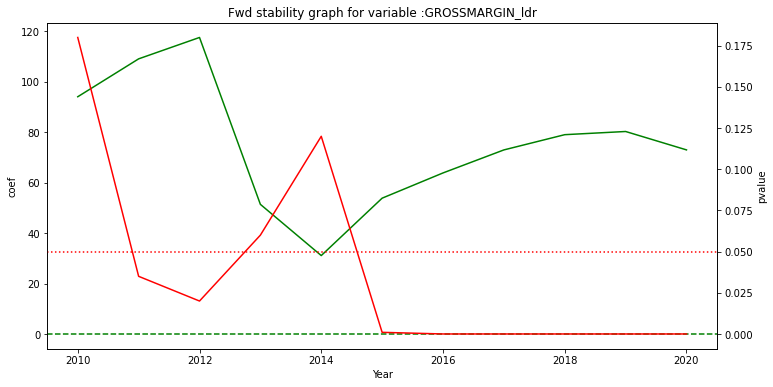

,variable,coef,pvalue,Iteration,Year,data_length,cumulative_length,AUC,Gini,Defaults,Cumulative_Defaults,DR,Culumative_DR
3,TDEBITDA_mod_ldr,60.04,0.16,1,"2,010.00",462,462,0.77,0.53,3,3,0.01,0.01
3,TDEBITDA_mod_ldr,43.23,0.20,2,"2,011.00",162,624,0.83,0.66,4,7,0.02,0.01
3,TDEBITDA_mod_ldr,38.23,0.23,3,"2,012.00",193,817,0.85,0.69,1,8,0.01,0.01
3,TDEBITDA_mod_ldr,19.47,0.45,4,"2,013.00",221,1038,0.80,0.61,5,13,0.02,0.01
3,TDEBITDA_mod_ldr,24.47,0.18,5,"2,014.00",264,1302,0.81,0.62,7,20,0.03,0.02
3,TDEBITDA_mod_ldr,31.70,0.03,6,"2,015.00",294,1596,0.83,0.66,12,32,0.04,0.02
3,TDEBITDA_mod_ldr,25.55,0.06,7,"2,016.00",294,1890,0.84,0.68,6,38,0.02,0.02
3,TDEBITDA_mod_ldr,22.71,0.08,8,"2,017.00",297,2187,0.84,0.67,6,44,0.02,0.02
3,TDEBITDA_mod_ldr,27.06,0.02,9,"2,018.00",304,2491,0.84,0.68,7,51,0.02,0.02
3,TDEBITDA_mod_ldr,21.37,0.06,10,"2,019.00",336,2827,0.85,0.70,10,61,0.03,0.02


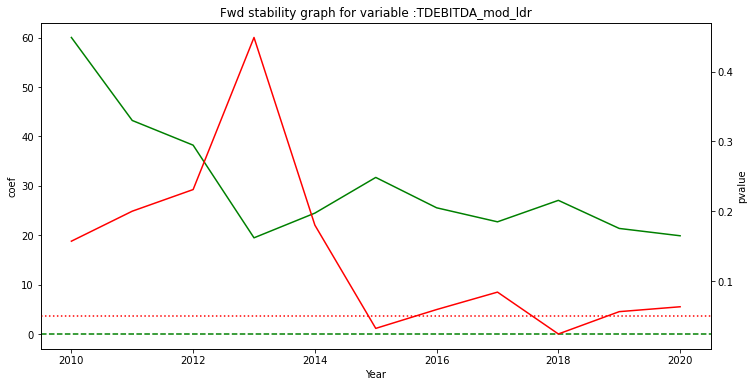

,variable,coef,pvalue,Iteration,Year,data_length,cumulative_length,AUC,Gini,Defaults,Cumulative_Defaults,DR,Culumative_DR
4,CURRENTRATIO_ldr,60.34,0.07,1,"2,010.00",462,462,0.77,0.53,3,3,0.01,0.01
4,CURRENTRATIO_ldr,31.54,0.12,2,"2,011.00",162,624,0.83,0.66,4,7,0.02,0.01
4,CURRENTRATIO_ldr,34.53,0.09,3,"2,012.00",193,817,0.85,0.69,1,8,0.01,0.01
4,CURRENTRATIO_ldr,26.52,0.07,4,"2,013.00",221,1038,0.80,0.61,5,13,0.02,0.01
4,CURRENTRATIO_ldr,30.79,0.01,5,"2,014.00",264,1302,0.81,0.62,7,20,0.03,0.02
4,CURRENTRATIO_ldr,40.45,0.00,6,"2,015.00",294,1596,0.83,0.66,12,32,0.04,0.02
4,CURRENTRATIO_ldr,42.40,0.00,7,"2,016.00",294,1890,0.84,0.68,6,38,0.02,0.02
4,CURRENTRATIO_ldr,43.22,0.00,8,"2,017.00",297,2187,0.84,0.67,6,44,0.02,0.02
4,CURRENTRATIO_ldr,43.52,0.00,9,"2,018.00",304,2491,0.84,0.68,7,51,0.02,0.02
4,CURRENTRATIO_ldr,44.36,0.00,10,"2,019.00",336,2827,0.85,0.70,10,61,0.03,0.02


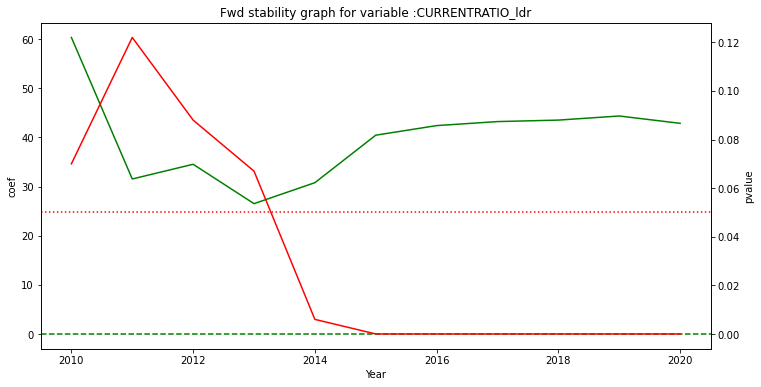

,variable,coef,pvalue,Iteration,Year,data_length,cumulative_length,AUC,Gini,Defaults,Cumulative_Defaults,DR,Culumative_DR
5,FIXEDCHARGECOVER_ldr,17.13,0.78,1,"2,010.00",462,462,0.77,0.53,3,3,0.01,0.01
5,FIXEDCHARGECOVER_ldr,58.37,0.25,2,"2,011.00",162,624,0.83,0.66,4,7,0.02,0.01
5,FIXEDCHARGECOVER_ldr,62.06,0.21,3,"2,012.00",193,817,0.85,0.69,1,8,0.01,0.01
5,FIXEDCHARGECOVER_ldr,67.13,0.06,4,"2,013.00",221,1038,0.80,0.61,5,13,0.02,0.01
5,FIXEDCHARGECOVER_ldr,53.94,0.04,5,"2,014.00",264,1302,0.81,0.62,7,20,0.03,0.02
5,FIXEDCHARGECOVER_ldr,41.78,0.04,6,"2,015.00",294,1596,0.83,0.66,12,32,0.04,0.02
5,FIXEDCHARGECOVER_ldr,39.70,0.03,7,"2,016.00",294,1890,0.84,0.68,6,38,0.02,0.02
5,FIXEDCHARGECOVER_ldr,34.77,0.04,8,"2,017.00",297,2187,0.84,0.67,6,44,0.02,0.02
5,FIXEDCHARGECOVER_ldr,33.53,0.03,9,"2,018.00",304,2491,0.84,0.68,7,51,0.02,0.02
5,FIXEDCHARGECOVER_ldr,36.15,0.01,10,"2,019.00",336,2827,0.85,0.70,10,61,0.03,0.02


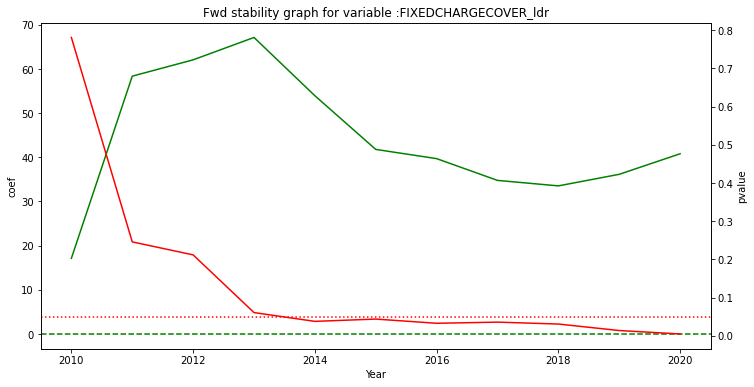

In [23]:
## Plot :
import matplotlib.pyplot as plt
import seaborn as sns

final_model_features= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']

print("Forward Stability Analysis : ")

for i in range (len(final_model_features)):
    variable=final_model_features[i]
    df_var=all_model_summarry_df[all_model_summarry_df['variable']==variable]
    display(df_var)
    # # draw lineplot

# setting the dimensions of the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(x="Year", y="coef", data=df_var,  color="g", ax=ax).set(title='Fwd stability graph for variable :{}'.format(variable))
    plt.axhline(y=0, color='g', linestyle='dashed')
    ax2 = plt.twinx()
    sns.lineplot(x="Year", y="pvalue", data=df_var,  color="r", ax=ax2)
    plt.axhline(y=0.05, color='r', linestyle='dotted')
    plt.show()
    

    

## Backward stability analysis :

In [24]:
## Backward stability analysis :

## Cross tab between rbs_stmtdate and rbs_group
import statsmodels.api as sd


year_list=df_dev['STATEMENTYEAR'].unique().tolist()
year_list.sort(reverse=True)

df_backward_dev=pd.DataFrame()

final_model_features= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']
segment_info=['rbs_stmtdate','rbs_group']
dep_var= ['default_flag3']
orignial_year=['STATEMENTYEAR']


final_var_list=final_model_features+dep_var+orignial_year


df_dev_stablty=df_dev[final_var_list].copy()
cum_year_list=[]
all_model_summarry_df_backward=pd.DataFrame()

## Since there are no defaults for 2007,2009 and 2010 : we assume all the records till 2010 as 2010 only.
df_dev_stablty['Updated_STATEMENTYEAR'] = np.where(df_dev_stablty['STATEMENTYEAR']<= 2010, 2010,df_dev_stablty['STATEMENTYEAR'] )
year_updated=['Updated_STATEMENTYEAR']

final_var_list=final_model_features+dep_var+year_updated

model_summary_df=pd.DataFrame()

year_list_new=df_dev_stablty['Updated_STATEMENTYEAR'].unique().tolist()
year_list_new.sort(reverse=True)

for i in range (len(year_list_new)):
    
    year=year_list_new[i]
    cum_year_list.append(year)
    
    df_backward_dev=df_dev_stablty[df_dev_stablty['Updated_STATEMENTYEAR']<=year]
    dev_data_year=df_dev_stablty[df_dev_stablty['Updated_STATEMENTYEAR']==year]
#     df_fwd_dev=pd.concat([df_fwd_dev, dev_data_year], axis=0)  # row wise stacking
    
    X_stablty=df_backward_dev[final_model_features].copy()
    y_stablty=df_backward_dev[dep_var].copy()
    
    # instantiate the classifier ,
    logistic_clf = LogisticRegression(penalty='none')
    model_stablty=logistic_clf.fit(X_stablty, y_stablty)

    y_stablty_proba=model_stablty.predict_proba(X_stablty)

    auc_stablty = roc_auc_score(y_stablty, y_stablty_proba[:,1])
    gini_stablty= 2*auc_stablty-1
    
    
    sd_model = sd.Logit(y_stablty, sm.add_constant(X_stablty)).fit(disp=0)
    results_summary = sd_model.summary()

    results_as_html = results_summary.tables[1].as_html()
    model_summary_df=pd.read_html(results_as_html, header=0, index_col=0)[0]
    model_summary_df=model_summary_df[['coef','P>|z|']].reset_index().rename(columns={'index':'variable','P>|z|':'pvalue'}).copy()
    
    model_summary_df['Iteration']=i+1
    model_summary_df['Year']=year
    model_summary_df['data_length']=len(dev_data_year)
    model_summary_df['cumulative_length']=len(df_backward_dev)
    model_summary_df['AUC']=auc_stablty
    model_summary_df['Gini']=gini_stablty
    model_summary_df['Defaults']=dev_data_year[dep_var].sum()[0]
    model_summary_df['Cumulative_Defaults']=df_backward_dev[dep_var].sum()[0]
    model_summary_df['DR']=model_summary_df['Defaults']/model_summary_df['data_length']
    model_summary_df['Cumulative_DR']=model_summary_df['Cumulative_Defaults']/model_summary_df['cumulative_length']
    
    
    
#     model_summary_df.at['Cumulative_Years']=cum_year_list
    
    all_model_summarry_df_backward=all_model_summarry_df_backward.append(model_summary_df)
    
    
#     df.at[1, 'Duration']

all_model_summarry_df_backward
    

    

,variable,coef,pvalue,Iteration,Year,data_length,cumulative_length,AUC,Gini,Defaults,Cumulative_Defaults,DR,Cumulative_DR
0,const,-9.86,0.00,1,"2,020.00",355,3182,0.86,0.71,6,67,0.02,0.02
1,NETSALES_ldr,44.83,0.00,1,"2,020.00",355,3182,0.86,0.71,6,67,0.02,0.02
2,GROSSMARGIN_ldr,73.00,0.00,1,"2,020.00",355,3182,0.86,0.71,6,67,0.02,0.02
3,TDEBITDA_mod_ldr,19.89,0.06,1,"2,020.00",355,3182,0.86,0.71,6,67,0.02,0.02
4,CURRENTRATIO_ldr,42.86,0.00,1,"2,020.00",355,3182,0.86,0.71,6,67,0.02,0.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1,NETSALES_ldr,-56.54,0.34,11,"2,010.00",462,462,0.77,0.53,3,3,0.01,0.01
2,GROSSMARGIN_ldr,94.07,0.18,11,"2,010.00",462,462,0.77,0.53,3,3,0.01,0.01
3,TDEBITDA_mod_ldr,60.04,0.16,11,"2,010.00",462,462,0.77,0.53,3,3,0.01,0.01
4,CURRENTRATIO_ldr,60.34,0.07,11,"2,010.00",462,462,0.77,0.53,3,3,0.01,0.01


In [26]:
## Just select model performance :

model_perf_summary = all_model_summarry_df_backward[['Year','Iteration','pvalue','data_length','cumulative_length',
                                            'Defaults','DR','Cumulative_Defaults','Cumulative_DR','AUC','Gini']]
model_perf_summary=model_perf_summary.groupby('Year').agg({'Iteration':'mean','pvalue':'max','data_length':'mean',
                                        'cumulative_length':'mean','Defaults':'mean','DR':'mean','Cumulative_Defaults':'mean',
                                                           'Cumulative_DR':'mean','AUC':'mean','Gini':'mean'})

model_perf_summary.rename(columns={'pvalue':'max_pvalue'}).reset_index()

model_perf_summary.sort_values(by='Year',ascending=False).reset_index()





,Year,Iteration,pvalue,data_length,cumulative_length,Defaults,DR,Cumulative_Defaults,Cumulative_DR,AUC,Gini
0,"2,020.00",1,0.06,355,3182,6,0.02,67,0.02,0.86,0.71
1,"2,019.00",2,0.06,336,2827,10,0.03,61,0.02,0.85,0.70
2,"2,018.00",3,0.03,304,2491,7,0.02,51,0.02,0.84,0.68
3,"2,017.00",4,0.08,297,2187,6,0.02,44,0.02,0.84,0.67
4,"2,016.00",5,0.06,294,1890,6,0.02,38,0.02,0.84,0.68
5,"2,015.00",6,0.13,294,1596,12,0.04,32,0.02,0.83,0.66
6,"2,014.00",7,0.69,264,1302,7,0.03,20,0.02,0.81,0.62
7,"2,013.00",8,0.91,221,1038,5,0.02,13,0.01,0.80,0.61
8,"2,012.00",9,0.70,193,817,1,0.01,8,0.01,0.85,0.69
9,"2,011.00",10,0.84,162,624,4,0.02,7,0.01,0.83,0.66


Bakcward Stability Analysis : 


,variable,coef,pvalue,Iteration,Year,data_length,cumulative_length,AUC,Gini,Defaults,Cumulative_Defaults,DR,Cumulative_DR
1,NETSALES_ldr,44.83,0.00,1,"2,020.00",355,3182,0.86,0.71,6,67,0.02,0.02
1,NETSALES_ldr,41.12,0.00,2,"2,019.00",336,2827,0.85,0.70,10,61,0.03,0.02
1,NETSALES_ldr,30.71,0.01,3,"2,018.00",304,2491,0.84,0.68,7,51,0.02,0.02
1,NETSALES_ldr,32.06,0.01,4,"2,017.00",297,2187,0.84,0.67,6,44,0.02,0.02
1,NETSALES_ldr,32.02,0.02,5,"2,016.00",294,1890,0.84,0.68,6,38,0.02,0.02
1,NETSALES_ldr,22.68,0.13,6,"2,015.00",294,1596,0.83,0.66,12,32,0.04,0.02
1,NETSALES_ldr,7.43,0.69,7,"2,014.00",264,1302,0.81,0.62,7,20,0.03,0.02
1,NETSALES_ldr,-2.55,0.91,8,"2,013.00",221,1038,0.80,0.61,5,13,0.02,0.01
1,NETSALES_ldr,-11.64,0.70,9,"2,012.00",193,817,0.85,0.69,1,8,0.01,0.01
1,NETSALES_ldr,-6.43,0.84,10,"2,011.00",162,624,0.83,0.66,4,7,0.02,0.01


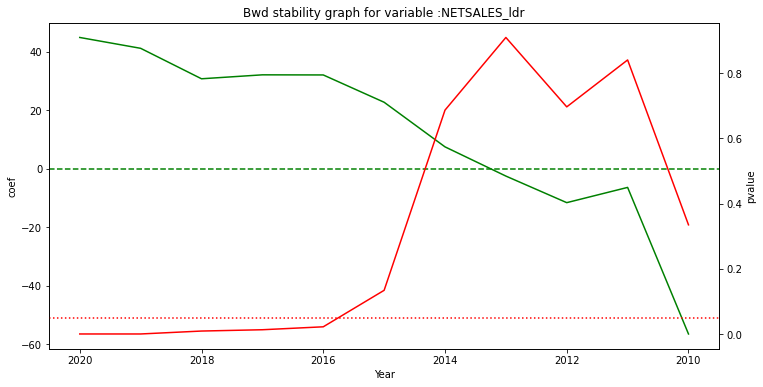

,variable,coef,pvalue,Iteration,Year,data_length,cumulative_length,AUC,Gini,Defaults,Cumulative_Defaults,DR,Cumulative_DR
2,GROSSMARGIN_ldr,73.00,0.00,1,"2,020.00",355,3182,0.86,0.71,6,67,0.02,0.02
2,GROSSMARGIN_ldr,80.29,0.00,2,"2,019.00",336,2827,0.85,0.70,10,61,0.03,0.02
2,GROSSMARGIN_ldr,79.03,0.00,3,"2,018.00",304,2491,0.84,0.68,7,51,0.02,0.02
2,GROSSMARGIN_ldr,72.99,0.00,4,"2,017.00",297,2187,0.84,0.67,6,44,0.02,0.02
2,GROSSMARGIN_ldr,63.86,0.00,5,"2,016.00",294,1890,0.84,0.68,6,38,0.02,0.02
2,GROSSMARGIN_ldr,53.85,0.00,6,"2,015.00",294,1596,0.83,0.66,12,32,0.04,0.02
2,GROSSMARGIN_ldr,31.09,0.12,7,"2,014.00",264,1302,0.81,0.62,7,20,0.03,0.02
2,GROSSMARGIN_ldr,51.40,0.06,8,"2,013.00",221,1038,0.80,0.61,5,13,0.02,0.01
2,GROSSMARGIN_ldr,117.58,0.02,9,"2,012.00",193,817,0.85,0.69,1,8,0.01,0.01
2,GROSSMARGIN_ldr,109.10,0.04,10,"2,011.00",162,624,0.83,0.66,4,7,0.02,0.01


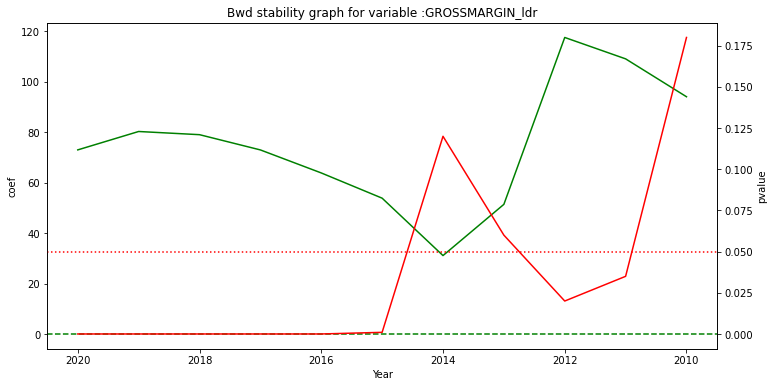

,variable,coef,pvalue,Iteration,Year,data_length,cumulative_length,AUC,Gini,Defaults,Cumulative_Defaults,DR,Cumulative_DR
3,TDEBITDA_mod_ldr,19.89,0.06,1,"2,020.00",355,3182,0.86,0.71,6,67,0.02,0.02
3,TDEBITDA_mod_ldr,21.37,0.06,2,"2,019.00",336,2827,0.85,0.70,10,61,0.03,0.02
3,TDEBITDA_mod_ldr,27.06,0.02,3,"2,018.00",304,2491,0.84,0.68,7,51,0.02,0.02
3,TDEBITDA_mod_ldr,22.71,0.08,4,"2,017.00",297,2187,0.84,0.67,6,44,0.02,0.02
3,TDEBITDA_mod_ldr,25.55,0.06,5,"2,016.00",294,1890,0.84,0.68,6,38,0.02,0.02
3,TDEBITDA_mod_ldr,31.70,0.03,6,"2,015.00",294,1596,0.83,0.66,12,32,0.04,0.02
3,TDEBITDA_mod_ldr,24.47,0.18,7,"2,014.00",264,1302,0.81,0.62,7,20,0.03,0.02
3,TDEBITDA_mod_ldr,19.47,0.45,8,"2,013.00",221,1038,0.80,0.61,5,13,0.02,0.01
3,TDEBITDA_mod_ldr,38.23,0.23,9,"2,012.00",193,817,0.85,0.69,1,8,0.01,0.01
3,TDEBITDA_mod_ldr,43.23,0.20,10,"2,011.00",162,624,0.83,0.66,4,7,0.02,0.01


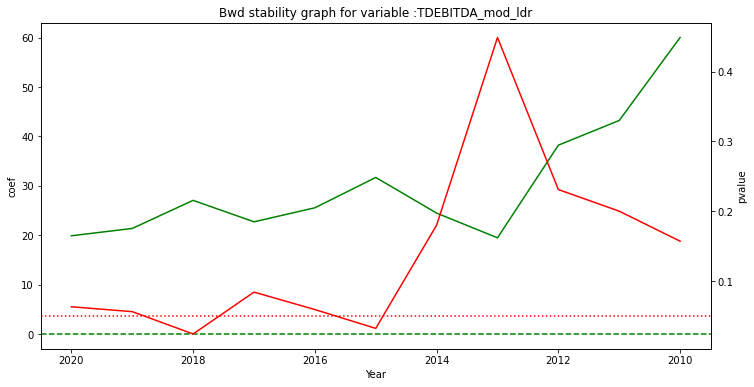

,variable,coef,pvalue,Iteration,Year,data_length,cumulative_length,AUC,Gini,Defaults,Cumulative_Defaults,DR,Cumulative_DR
4,CURRENTRATIO_ldr,42.86,0.00,1,"2,020.00",355,3182,0.86,0.71,6,67,0.02,0.02
4,CURRENTRATIO_ldr,44.36,0.00,2,"2,019.00",336,2827,0.85,0.70,10,61,0.03,0.02
4,CURRENTRATIO_ldr,43.52,0.00,3,"2,018.00",304,2491,0.84,0.68,7,51,0.02,0.02
4,CURRENTRATIO_ldr,43.22,0.00,4,"2,017.00",297,2187,0.84,0.67,6,44,0.02,0.02
4,CURRENTRATIO_ldr,42.40,0.00,5,"2,016.00",294,1890,0.84,0.68,6,38,0.02,0.02
4,CURRENTRATIO_ldr,40.45,0.00,6,"2,015.00",294,1596,0.83,0.66,12,32,0.04,0.02
4,CURRENTRATIO_ldr,30.79,0.01,7,"2,014.00",264,1302,0.81,0.62,7,20,0.03,0.02
4,CURRENTRATIO_ldr,26.52,0.07,8,"2,013.00",221,1038,0.80,0.61,5,13,0.02,0.01
4,CURRENTRATIO_ldr,34.53,0.09,9,"2,012.00",193,817,0.85,0.69,1,8,0.01,0.01
4,CURRENTRATIO_ldr,31.54,0.12,10,"2,011.00",162,624,0.83,0.66,4,7,0.02,0.01


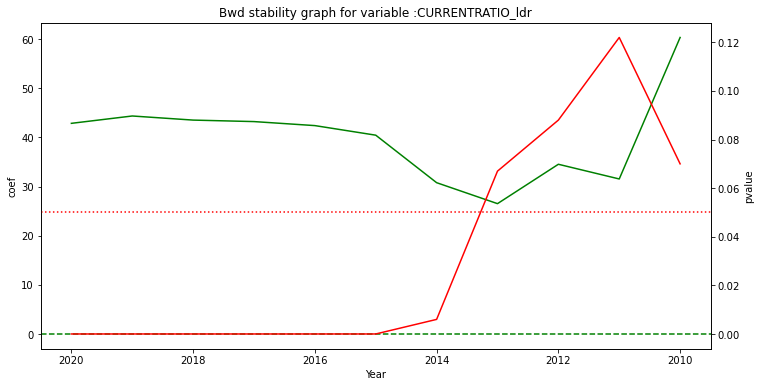

,variable,coef,pvalue,Iteration,Year,data_length,cumulative_length,AUC,Gini,Defaults,Cumulative_Defaults,DR,Cumulative_DR
5,FIXEDCHARGECOVER_ldr,40.80,0.01,1,"2,020.00",355,3182,0.86,0.71,6,67,0.02,0.02
5,FIXEDCHARGECOVER_ldr,36.15,0.01,2,"2,019.00",336,2827,0.85,0.70,10,61,0.03,0.02
5,FIXEDCHARGECOVER_ldr,33.53,0.03,3,"2,018.00",304,2491,0.84,0.68,7,51,0.02,0.02
5,FIXEDCHARGECOVER_ldr,34.77,0.04,4,"2,017.00",297,2187,0.84,0.67,6,44,0.02,0.02
5,FIXEDCHARGECOVER_ldr,39.70,0.03,5,"2,016.00",294,1890,0.84,0.68,6,38,0.02,0.02
5,FIXEDCHARGECOVER_ldr,41.78,0.04,6,"2,015.00",294,1596,0.83,0.66,12,32,0.04,0.02
5,FIXEDCHARGECOVER_ldr,53.94,0.04,7,"2,014.00",264,1302,0.81,0.62,7,20,0.03,0.02
5,FIXEDCHARGECOVER_ldr,67.13,0.06,8,"2,013.00",221,1038,0.80,0.61,5,13,0.02,0.01
5,FIXEDCHARGECOVER_ldr,62.06,0.21,9,"2,012.00",193,817,0.85,0.69,1,8,0.01,0.01
5,FIXEDCHARGECOVER_ldr,58.37,0.25,10,"2,011.00",162,624,0.83,0.66,4,7,0.02,0.01


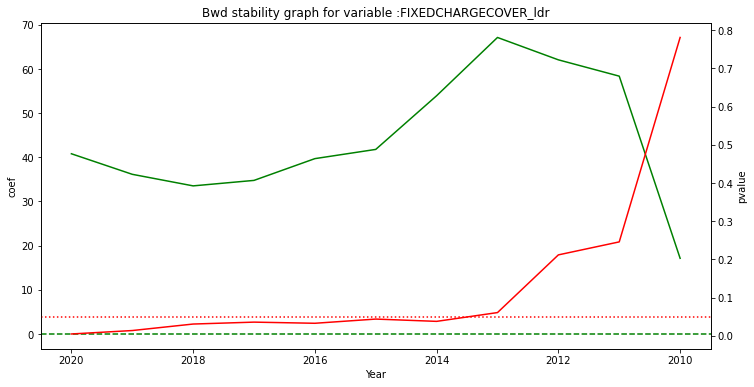

In [48]:
## Plot :
import matplotlib.pyplot as plt
import seaborn as sns

final_model_features= ['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr','CURRENTRATIO_ldr','FIXEDCHARGECOVER_ldr']

print("Bakcward Stability Analysis : ")

for i in range (len(final_model_features)):
    variable=final_model_features[i]
    df_var=all_model_summarry_df_backward[all_model_summarry_df_backward['variable']==variable]
    df_var_sorted=df_var.sort_values(by='Year',ascending=False).reset_index().copy()
    display(df_var)
    


# setting the dimensions of the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.lineplot(x="Year", y="coef", data=df_var_sorted,  color="g", ax=ax).set(title='Bwd stability graph for variable :{}'.format(variable))
    plt.axhline(y=0, color='g', linestyle='dashed')
    ax.invert_xaxis()
    
    

    
    ax2 = plt.twinx()
    sns.lineplot(x="Year", y="pvalue", data=df_var_sorted,  color="r", ax=ax2)


    
    
    plt.axhline(y=0.05, color='r', linestyle='dotted')
    plt.show()
    

    

## Sec 4 Sensitivity analysis using coefficient shocks : 

## 4.1 Sensitivity analysis with original model coefficients : 

In [142]:
import math

def sensitivity_analysis(df,ypred_proba,shock):
    
    C1=37.6188
    C2=64.7968
    C3=21.1106
    C4=40.3872
    C5=38.1627
    
    C1_new=C1*(1+shock)
    C2_new=C2*(1+shock)
    C3_new=C3*(1+shock)
    C4_new=C4*(1+shock)
    C5_new=C5*(1+shock)

        
       
    sensitivity_vars=['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr', 'CURRENTRATIO_ldr', 'FIXEDCHARGECOVER_ldr','default_flag3']

    df_sensitivity=df[sensitivity_vars].reset_index()
    ypred_proba_df=pd.DataFrame(ypred_proba)
    
    df_sensitivity=pd.concat([df_sensitivity, ypred_proba_df], axis=1)
    df_sensitivity=df_sensitivity.drop(['index'], axis=1)
    df_sensitivity=df_sensitivity.rename(columns={0:'predicted_prob_frm_model'})
          
    
    df_sensitivity['exp_lin_orig']=-9.2289+C1*df_sensitivity['NETSALES_ldr']+C2*df_sensitivity['GROSSMARGIN_ldr']+C3*df_sensitivity['TDEBITDA_mod_ldr']+C4*df_sensitivity['CURRENTRATIO_ldr']+C5*df_sensitivity['FIXEDCHARGECOVER_ldr']
    
    df_sensitivity['exp_lin_shock']=-9.2289+C1_new*df_sensitivity['NETSALES_ldr']+C2_new*df_sensitivity['GROSSMARGIN_ldr']+C3_new*df_sensitivity['TDEBITDA_mod_ldr']+C4_new*df_sensitivity['CURRENTRATIO_ldr']+C5_new*df_sensitivity['FIXEDCHARGECOVER_ldr']
    
    df_sensitivity['predctd_prob_w_senstvty']= df_sensitivity.apply(lambda row: (1/(1+math.exp(-row.exp_lin_shock))) , axis = 1)

    
    return df_sensitivity['predctd_prob_w_senstvty'].mean(),df_sensitivity['predicted_prob_frm_model'].mean()

In [153]:
sensitivity_analysis(df_oot,ypred_oot_proba,0.05)

(0.020224916308351524, 0.015389614974031901)

In [168]:
pd.options.display.float_format = '{:,.3f}'.format

shock_range=[-0.1,-0.08,-0.07,-0.05,-0.03,-0.01,0.01,0.03,0.05,0.07,0.08,0.1]

df_senstvty_summary=pd.DataFrame()
df_senstvty_summary_total_oot=pd.DataFrame()


for shock in (shock_range):
    df_senstvty_summary=pd.DataFrame()
    Data='OOT'
    avg_portfolio_predicted_pd=sensitivity_analysis(df_oot,ypred_oot_proba,shock)[1]
    avg_portfolio_shocked_pd=sensitivity_analysis(df_oot,ypred_oot_proba,shock)[0]
    shock_pctg=shock*100
    pd_difference_abs=(avg_portfolio_predicted_pd-avg_portfolio_shocked_pd)
    pd_difference_pctg=(avg_portfolio_predicted_pd-avg_portfolio_shocked_pd)*100/avg_portfolio_shocked_pd
    
    df_senstvty_summary=pd.DataFrame([[Data,shock_pctg,avg_portfolio_predicted_pd,avg_portfolio_shocked_pd,pd_difference_abs,pd_difference_pctg]],
                                      columns=['Data','shock_pctg','avg_portfolio_predicted_pd','avg_portfolio_shocked_pd','pd_difference_abs','pd_difference_pctg'])
    
    df_senstvty_summary_total_oot=df_senstvty_summary_total_oot.append(df_senstvty_summary)

df_senstvty_summary_total_oot    

,Data,shock_pctg,avg_portfolio_predicted_pd,avg_portfolio_shocked_pd,pd_difference_abs,pd_difference_pctg
0,OOT,-10.000,0.015,0.009,0.007,74.371
0,OOT,-8.000,0.015,0.010,0.006,55.947
0,OOT,-7.000,0.015,0.010,0.005,47.485
0,OOT,-5.000,0.015,0.012,0.004,31.931
0,OOT,-3.000,0.015,0.013,0.002,18.051
0,OOT,-1.000,0.015,0.015,0.001,5.675
0,OOT,1.000,0.015,0.016,-0.001,-5.353
0,OOT,3.000,0.015,0.018,-0.003,-15.171
0,OOT,5.000,0.015,0.020,-0.005,-23.908
0,OOT,7.000,0.015,0.023,-0.007,-31.676


## 4.2 Sensitivity Analysis with calculated model weights: 

In [16]:
import math

def sensitivity_analysis(df,ypred_proba,shock):
    
    C1=12.98
    C2=30.68
    C3=13.69
    C4=27.6
    C5=15.05
    
    C1_new=C1*(1+shock)
    C2_new=C2*(1+shock)
    C3_new=C3*(1+shock)
    C4_new=C4*(1+shock)
    C5_new=C5*(1+shock)

        
       
    sensitivity_vars=['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr', 'CURRENTRATIO_ldr', 'FIXEDCHARGECOVER_ldr','default_flag3']

    df_sensitivity=df[sensitivity_vars].reset_index()
    ypred_proba_df=pd.DataFrame(ypred_proba)
    
    df_sensitivity=pd.concat([df_sensitivity, ypred_proba_df], axis=1)
    df_sensitivity=df_sensitivity.drop(['index'], axis=1)
    df_sensitivity=df_sensitivity.rename(columns={0:'predicted_prob_frm_model'})
          
    
    df_sensitivity['exp_lin_orig']=-9.2289+C1*df_sensitivity['NETSALES_ldr']+C2*df_sensitivity['GROSSMARGIN_ldr']+C3*df_sensitivity['TDEBITDA_mod_ldr']+C4*df_sensitivity['CURRENTRATIO_ldr']+C5*df_sensitivity['FIXEDCHARGECOVER_ldr']
    
    df_sensitivity['exp_lin_shock']=-9.2289+C1_new*df_sensitivity['NETSALES_ldr']+C2_new*df_sensitivity['GROSSMARGIN_ldr']+C3_new*df_sensitivity['TDEBITDA_mod_ldr']+C4_new*df_sensitivity['CURRENTRATIO_ldr']+C5_new*df_sensitivity['FIXEDCHARGECOVER_ldr']
    
    df_sensitivity['Orig_predctd_prob']= df_sensitivity.apply(lambda row: (1/(1+math.exp(-row.exp_lin_orig))) , axis = 1)
    
    df_sensitivity['predctd_prob_w_senstvty']= df_sensitivity.apply(lambda row: (1/(1+math.exp(-row.exp_lin_shock))) , axis = 1)

    
    return df_sensitivity['predctd_prob_w_senstvty'].mean(),df_sensitivity['Orig_predctd_prob'].mean(),df_sensitivity['predicted_prob_frm_model'].mean(),

In [18]:
## Sensitivity analsysis with calculated model weights on OOT Data

pd.options.display.float_format = '{:,.5f}'.format

shock_range=[-0.1,-0.08,-0.07,-0.05,-0.03,-0.01,0,0.01,0.03,0.05,0.07,0.08,0.1]

df_senstvty_summary=pd.DataFrame()
df_senstvty_summary_total_oot=pd.DataFrame()

df_oot = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] >= 2021,:].copy()

for shock in (shock_range):
    df_senstvty_summary=pd.DataFrame()
    Data='OOT'
    avg_portfolio_predicted_pd=sensitivity_analysis(df_oot,ypred_oot_proba,shock)[1]
    avg_portfolio_shocked_pd=sensitivity_analysis(df_oot,ypred_oot_proba,shock)[0]
    shock_pctg=shock*100
    pd_difference_abs=(avg_portfolio_predicted_pd-avg_portfolio_shocked_pd)
    pd_difference_pctg=(avg_portfolio_predicted_pd-avg_portfolio_shocked_pd)*100/avg_portfolio_shocked_pd
    
    df_senstvty_summary=pd.DataFrame([[Data,shock_pctg,avg_portfolio_predicted_pd,avg_portfolio_shocked_pd,pd_difference_abs,pd_difference_pctg]],
                                      columns=['Data','shock_pctg','avg_portfolio_predicted_pd','avg_portfolio_shocked_pd','pd_difference_abs','pd_difference_pctg'])
    
    df_senstvty_summary_total_oot=df_senstvty_summary_total_oot.append(df_senstvty_summary)
    
print("Sensitivity analsysis with calculated model weights on OOT Data")

df_senstvty_summary_total_oot    

Sensitivity analsysis with calculated model weights on OOT Data


,Data,shock_pctg,avg_portfolio_predicted_pd,avg_portfolio_shocked_pd,pd_difference_abs,pd_difference_pctg
0,OOT,-10.00000,0.00097,0.00075,0.00022,28.73394
0,OOT,-8.00000,0.00097,0.00079,0.00018,22.44507
0,OOT,-7.00000,0.00097,0.00081,0.00016,19.40715
0,OOT,-5.00000,0.00097,0.00085,0.00012,13.53722
0,OOT,-3.00000,0.00097,0.00090,0.00007,7.93264
0,OOT,-1.00000,0.00097,0.00094,0.00002,2.58271
0,OOT,0.00000,0.00097,0.00097,0.00000,0.00000
0,OOT,1.00000,0.00097,0.00099,-0.00003,-2.52290
0,OOT,3.00000,0.00097,0.00104,-0.00008,-7.39416
0,OOT,5.00000,0.00097,0.00110,-0.00013,-12.04071


## 4.3 Sensitivity Analysis with adjusted model weights: 

In [19]:
import math

def sensitivity_analysis(df,ypred_proba,shock):
    
    C1=15
    C2=25
    C3=20
    C4=20
    C5=20
    
    C1_new=C1*(1+shock)
    C2_new=C2*(1+shock)
    C3_new=C3*(1+shock)
    C4_new=C4*(1+shock)
    C5_new=C5*(1+shock)

        
       
    sensitivity_vars=['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr', 'CURRENTRATIO_ldr', 'FIXEDCHARGECOVER_ldr','default_flag3']

    df_sensitivity=df[sensitivity_vars].reset_index()
    ypred_proba_df=pd.DataFrame(ypred_proba)
    
    df_sensitivity=pd.concat([df_sensitivity, ypred_proba_df], axis=1)
    df_sensitivity=df_sensitivity.drop(['index'], axis=1)
    df_sensitivity=df_sensitivity.rename(columns={0:'predicted_prob_frm_model'})
          
    
    df_sensitivity['exp_lin_orig']=-9.2289+C1*df_sensitivity['NETSALES_ldr']+C2*df_sensitivity['GROSSMARGIN_ldr']+C3*df_sensitivity['TDEBITDA_mod_ldr']+C4*df_sensitivity['CURRENTRATIO_ldr']+C5*df_sensitivity['FIXEDCHARGECOVER_ldr']
    
    df_sensitivity['exp_lin_shock']=-9.2289+C1_new*df_sensitivity['NETSALES_ldr']+C2_new*df_sensitivity['GROSSMARGIN_ldr']+C3_new*df_sensitivity['TDEBITDA_mod_ldr']+C4_new*df_sensitivity['CURRENTRATIO_ldr']+C5_new*df_sensitivity['FIXEDCHARGECOVER_ldr']
    
    df_sensitivity['Orig_predctd_prob']= df_sensitivity.apply(lambda row: (1/(1+math.exp(-row.exp_lin_orig))) , axis = 1)
    
    df_sensitivity['predctd_prob_w_senstvty']= df_sensitivity.apply(lambda row: (1/(1+math.exp(-row.exp_lin_shock))) , axis = 1)

    
    return df_sensitivity['predctd_prob_w_senstvty'].mean(),df_sensitivity['Orig_predctd_prob'].mean(),df_sensitivity['predicted_prob_frm_model'].mean(),

In [20]:
## Sensitivity analsysis with adjusted model weights on OOT Data

pd.options.display.float_format = '{:,.5f}'.format

shock_range=[-0.1,-0.08,-0.07,-0.05,-0.03,-0.01,0,0.01,0.03,0.05,0.07,0.08,0.1]

df_senstvty_summary=pd.DataFrame()
df_senstvty_summary_total_oot=pd.DataFrame()

df_oot = final_mdlg_data.loc[final_mdlg_data['STATEMENTYEAR'] >= 2021,:].copy()

for shock in (shock_range):
    df_senstvty_summary=pd.DataFrame()
    Data='OOT'
    avg_portfolio_predicted_pd=sensitivity_analysis(df_oot,ypred_oot_proba,shock)[1]
    avg_portfolio_shocked_pd=sensitivity_analysis(df_oot,ypred_oot_proba,shock)[0]
    shock_pctg=shock*100
    pd_difference_abs=(avg_portfolio_predicted_pd-avg_portfolio_shocked_pd)
    pd_difference_pctg=(avg_portfolio_predicted_pd-avg_portfolio_shocked_pd)*100/avg_portfolio_shocked_pd
    
    df_senstvty_summary=pd.DataFrame([[Data,shock_pctg,avg_portfolio_predicted_pd,avg_portfolio_shocked_pd,pd_difference_abs,pd_difference_pctg]],
                                      columns=['Data','shock_pctg','avg_portfolio_predicted_pd','avg_portfolio_shocked_pd','pd_difference_abs','pd_difference_pctg'])
    
    df_senstvty_summary_total_oot=df_senstvty_summary_total_oot.append(df_senstvty_summary)
    
print("Sensitivity analsysis with model weights on OOT Data")

df_senstvty_summary_total_oot    

Sensitivity analsysis with model weights on OOT Data


,Data,shock_pctg,avg_portfolio_predicted_pd,avg_portfolio_shocked_pd,pd_difference_abs,pd_difference_pctg
0,OOT,-10.00000,0.00102,0.00079,0.00023,29.10173
0,OOT,-8.00000,0.00102,0.00083,0.00019,22.71618
0,OOT,-7.00000,0.00102,0.00086,0.00017,19.63473
0,OOT,-5.00000,0.00102,0.00090,0.00012,13.68665
0,OOT,-3.00000,0.00102,0.00095,0.00008,8.01492
0,OOT,-1.00000,0.00102,0.00100,0.00003,2.60784
0,OOT,0.00000,0.00102,0.00102,0.00000,0.00000
0,OOT,1.00000,0.00102,0.00105,-0.00003,-2.54587
0,OOT,3.00000,0.00102,0.00111,-0.00008,-7.45706
0,OOT,5.00000,0.00102,0.00116,-0.00014,-12.13616


## 4.3 Sensitivity Analysis by shcoking model variables one at a time: 

In [38]:

import math
# importing the statistics module
from statistics import stdev






sensitivity_vars=['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr', 'CURRENTRATIO_ldr', 'FIXEDCHARGECOVER_ldr']

df_sensitivity=X_train.reset_index()
ypred_proba_df=pd.DataFrame(ypred_train_proba)

df_sensitivity=pd.concat([df_sensitivity, ypred_proba_df], axis=1)
df_sensitivity=df_sensitivity.drop(['index'], axis=1)
df_sensitivity=df_sensitivity.rename(columns={0:'predicted_prob_frm_model'})

df_senstvty_summary=pd.DataFrame()
df_senstvty_summary_total=pd.DataFrame()

original_mean_pred_pd=ypred_train_proba.mean()



for var in sensitivity_vars :
    one_sigma=stdev(df_sensitivity[var])
    two_sigma=2*stdev(df_sensitivity[var])
    three_sigma=3*stdev(df_sensitivity[var])
    
    
    df_sensitivity[var+str('_plus_1_sig')]=df_sensitivity[var]+one_sigma
    model_features_new_plus_one_sig =  [var+str('_plus_1_sig') if item == str(var) else item for item in sensitivity_vars]
    pred_prob_mean_one_sig_plus=model.predict_proba(df_sensitivity[model_features_new_plus_one_sig])[:,1].mean()
    
    df_sensitivity[var+str('_minus_1_sig')]=df_sensitivity[var]-one_sigma
    model_features_new_minus_one_sig =  [var+str('_minus_1_sig') if item == str(var) else item for item in sensitivity_vars]
    pred_prob_mean_one_sig_minus=model.predict_proba(df_sensitivity[model_features_new_minus_one_sig])[:,1].mean()
    
    df_sensitivity[var+str('_plus_2_sig')]=df_sensitivity[var]+two_sigma
    model_features_new_plus_two_sig =  [var+str('_plus_2_sig') if item == str(var) else item for item in sensitivity_vars]
    pred_prob_mean_two_sig_plus=model.predict_proba(df_sensitivity[model_features_new_plus_two_sig])[:,1].mean()
    
    df_sensitivity[var+str('_minus_2_sig')]=df_sensitivity[var]-two_sigma
    model_features_new_minus_two_sig =  [var+str('_minus_2_sig') if item == str(var) else item for item in sensitivity_vars]
    pred_prob_mean_two_sig_minus=model.predict_proba(df_sensitivity[model_features_new_minus_two_sig])[:,1].mean()
    
    df_sensitivity[var+str('_plus_3_sig')]=df_sensitivity[var]+three_sigma
    model_features_new_plus_three_sig =  [var+str('_plus_3_sig') if item == str(var) else item for item in sensitivity_vars]
    pred_prob_mean_three_sig_plus=model.predict_proba(df_sensitivity[model_features_new_plus_three_sig])[:,1].mean()
    
    df_sensitivity[var+str('_minus_3_sig')]=df_sensitivity[var]-three_sigma
    model_features_new_minus_three_sig =  [var+str('_minus_3_sig') if item == str(var) else item for item in sensitivity_vars]
    pred_prob_mean_three_sig_minus=model.predict_proba(df_sensitivity[model_features_new_minus_three_sig])[:,1].mean()
    
    
    
    df_senstvty_summary=pd.DataFrame([[var,original_mean_pred_pd,pred_prob_mean_one_sig_plus,pred_prob_mean_one_sig_minus,
                                       pred_prob_mean_two_sig_plus,pred_prob_mean_two_sig_minus,pred_prob_mean_three_sig_plus,
                                      pred_prob_mean_three_sig_minus]],
                                      columns=['Variable','original_mean_pred_pd','avg_pred_pd_onesig_plus','avg_pred_pd_onesig_minus',
                                               'avg_pred_pd_twosig_plus','avg_pred_pd_twosig_minus',
                                              'avg_pred_pd_threesig_plus','avg_pred_pd_threesig_minus'])
    
    df_senstvty_summary_total=df_senstvty_summary_total.append(df_senstvty_summary)
    
        

    
    


In [39]:
df_senstvty_summary_total

,Variable,original_mean_pred_pd,avg_pred_pd_onesig_plus,avg_pred_pd_onesig_minus,avg_pred_pd_twosig_plus,avg_pred_pd_twosig_minus,avg_pred_pd_threesig_plus,avg_pred_pd_threesig_minus
0,NETSALES_ldr,0.02,0.03,0.01,0.05,0.01,0.08,0.01
0,GROSSMARGIN_ldr,0.02,0.04,0.01,0.09,0.00,0.16,0.00
0,TDEBITDA_mod_ldr,0.02,0.03,0.02,0.03,0.01,0.04,0.01
0,CURRENTRATIO_ldr,0.02,0.04,0.01,0.08,0.00,0.14,0.00
0,FIXEDCHARGECOVER_ldr,0.02,0.03,0.01,0.06,0.01,0.09,0.00


In [11]:

import math
# importing the statistics module
from statistics import stdev

pd.options.display.float_format = '{:,.3f}'.format






sensitivity_vars=['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr', 'CURRENTRATIO_ldr', 'FIXEDCHARGECOVER_ldr']

df_sensitivity=X_train.reset_index()
ypred_proba_df=pd.DataFrame(ypred_train_proba)

df_sensitivity=pd.concat([df_sensitivity, ypred_proba_df], axis=1)
df_sensitivity=df_sensitivity.drop(['index'], axis=1)
df_sensitivity=df_sensitivity.rename(columns={0:'predicted_prob_frm_model'})

df_senstvty_summary=pd.DataFrame()
df_senstvty_summary_total=pd.DataFrame()

original_mean_pred_pd=ypred_train_proba.mean()



for var in sensitivity_vars :
    one_sigma=stdev(df_sensitivity[var])
    two_sigma=2*stdev(df_sensitivity[var])
    three_sigma=3*stdev(df_sensitivity[var])
    
    sigma_list=[one_sigma,two_sigma,three_sigma]
    
    sigma_name=['one_sigma','two_sigma','three_sigma']
    
    for sigma in range(len(sigma_list)):  
        
        df_sensitivity[var+str('_plus_')+str(sigma_name[sigma])]=df_sensitivity[var]+sigma_list[sigma]
        model_features_new_plus_sig =  [var+str('_plus_')+str(sigma_name[sigma]) if item == str(var) else item for item in sensitivity_vars]
        pred_prob_mean_sig_plus=model.predict_proba(df_sensitivity[model_features_new_plus_sig])[:,1].mean()
        
        df_sensitivity[var+str('_minus_')+str(sigma_name[sigma])]=df_sensitivity[var]-sigma_list[sigma]
        model_features_new_minus_sig =  [var+str('_minus_')+str(sigma_name[sigma]) if item == str(var) else item for item in sensitivity_vars]
        pred_prob_mean_sig_minus=model.predict_proba(df_sensitivity[model_features_new_minus_sig])[:,1].mean()
        
          
        df_senstvty_summary=pd.DataFrame([[var,original_mean_pred_pd,sigma_name[sigma],pred_prob_mean_sig_plus,
                                           pred_prob_mean_sig_minus]],
                                      columns=['Variable','original_mean_pred_pd','Sigma','avg_pred_pd_plus',
                                               'avg_pred_pd_minus'])
    
        df_senstvty_summary_total=df_senstvty_summary_total.append(df_senstvty_summary)
        df_senstvty_summary_total['Pd_diff_plus_pctg']=(df_senstvty_summary_total['avg_pred_pd_plus']-df_senstvty_summary_total['original_mean_pred_pd'])*100/df_senstvty_summary_total['original_mean_pred_pd']
        df_senstvty_summary_total['Pd_diff_minus_pctg']=(df_senstvty_summary_total['avg_pred_pd_minus']-df_senstvty_summary_total['original_mean_pred_pd'])*100/df_senstvty_summary_total['original_mean_pred_pd']
        

    

df_senstvty_summary_total


,Variable,original_mean_pred_pd,Sigma,avg_pred_pd_plus,avg_pred_pd_minus,Pd_diff_plus_pctg,Pd_diff_minus_pctg
0,NETSALES_ldr,0.021,one_sigma,0.033,0.013,57.428,-37.464
0,NETSALES_ldr,0.021,two_sigma,0.052,0.008,142.923,-61.343
0,NETSALES_ldr,0.021,three_sigma,0.078,0.005,265.762,-76.299
0,GROSSMARGIN_ldr,0.021,one_sigma,0.045,0.010,110.810,-54.587
0,GROSSMARGIN_ldr,0.021,two_sigma,0.088,0.004,316.850,-79.906
0,GROSSMARGIN_ldr,0.021,three_sigma,0.161,0.002,658.465,-91.230
0,TDEBITDA_mod_ldr,0.021,one_sigma,0.027,0.017,26.633,-21.358
0,TDEBITDA_mod_ldr,0.021,two_sigma,0.034,0.013,59.600,-38.375
0,TDEBITDA_mod_ldr,0.021,three_sigma,0.042,0.010,100.076,-51.857
0,CURRENTRATIO_ldr,0.021,one_sigma,0.042,0.010,97.092,-51.046


## Sensitivity analysis with %age change : 

In [21]:

import math
# importing the statistics module
from statistics import stdev

pd.options.display.float_format = '{:,.3f}'.format

shock_range=[-0.1,-0.07,-0.05,-0.03,0,0.03,0.05,0.07,0.1]

sensitivity_vars=['NETSALES_ldr', 'GROSSMARGIN_ldr', 'TDEBITDA_mod_ldr', 'CURRENTRATIO_ldr', 'FIXEDCHARGECOVER_ldr']

df_sensitivity=X_train.reset_index()
ypred_proba_df=pd.DataFrame(ypred_train_proba)

df_sensitivity=pd.concat([df_sensitivity, ypred_proba_df], axis=1)
df_sensitivity=df_sensitivity.drop(['index'], axis=1)
df_sensitivity=df_sensitivity.rename(columns={0:'predicted_prob_frm_model'})

df_senstvty_summary=pd.DataFrame()
df_senstvty_summary_total=pd.DataFrame()

original_mean_pred_pd=ypred_train_proba.mean()



for var in sensitivity_vars :

    
    for shock in (shock_range):
        
        df_senstvty_summary=pd.DataFrame()
        
        df_sensitivity[var+str('_plus_')+str(shock)]=df_sensitivity[var]*(1+shock)
        model_features_new_plus_shock =  [var+str('_plus_')+str(shock) if item == str(var) else item for item in sensitivity_vars]
        pred_prob_mean_plus=model.predict_proba(df_sensitivity[model_features_new_plus_shock])[:,1].mean()
        
        df_sensitivity[var+str('_minus_')+str(shock)]=df_sensitivity[var]*(1-shock)
        model_features_new_minus_shock =  [var+str('_minus_')+str(shock) if item == str(var) else item for item in sensitivity_vars]
        pred_prob_mean_minus=model.predict_proba(df_sensitivity[model_features_new_minus_shock])[:,1].mean()
        

        
          
        df_senstvty_summary=pd.DataFrame([[var,original_mean_pred_pd,shock*100,pred_prob_mean_plus,
                                           pred_prob_mean_minus]],
                                      columns=['Variable','original_mean_pred_pd','Shock %age','avg_pred_pd_plus',
                                               'avg_pred_pd_minus'])
    
        df_senstvty_summary_total=df_senstvty_summary_total.append(df_senstvty_summary)
        df_senstvty_summary_total['Pd_diff_plus_pctg']=(df_senstvty_summary_total['avg_pred_pd_plus']-df_senstvty_summary_total['original_mean_pred_pd'])*100/df_senstvty_summary_total['original_mean_pred_pd']
        df_senstvty_summary_total['Pd_diff_minus_pctg']=(df_senstvty_summary_total['avg_pred_pd_minus']-df_senstvty_summary_total['original_mean_pred_pd'])*100/df_senstvty_summary_total['original_mean_pred_pd']
        

    

df_senstvty_summary_total


,Variable,original_mean_pred_pd,Shock %age,avg_pred_pd_plus,avg_pred_pd_minus,Pd_diff_plus_pctg,Pd_diff_minus_pctg
0,NETSALES_ldr,0.021,-10.000,0.019,0.024,-9.708,10.813
0,NETSALES_ldr,0.021,-7.000,0.020,0.023,-6.906,7.447
0,NETSALES_ldr,0.021,-5.000,0.020,0.022,-4.986,5.262
0,NETSALES_ldr,0.021,-3.000,0.021,0.022,-3.024,3.123
0,NETSALES_ldr,0.021,0.000,0.021,0.021,0.000,0.000
0,NETSALES_ldr,0.021,3.000,0.022,0.021,3.123,-3.024
0,NETSALES_ldr,0.021,5.000,0.022,0.020,5.262,-4.986
0,NETSALES_ldr,0.021,7.000,0.023,0.020,7.447,-6.906
0,NETSALES_ldr,0.021,10.000,0.024,0.019,10.813,-9.708
0,GROSSMARGIN_ldr,0.021,-10.000,0.018,0.025,-15.330,18.326
